<a href="https://colab.research.google.com/github/thisishasan/data_mining_and_machine_learning/blob/main/data_mining_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Domain: Environment

Application Scenario: CO2 emissions

Data Type: Multivariate Time series

Dataset Link: https://carbonmonitor.org/

Objective: Anomaly detection, structural breaks, clustering of countries


https://arxiv.org/pdf/2405.02340?

https://arxiv.org/html/2412.20582v1#bib

https://otexts.com/fpp3/expsmooth.html

https://www.datacamp.com/tutorial/isolation-forest?utm_cid=19589720821&utm_aid=157156374951&utm_campaign=230119_1-ps-other~dsa-tofu~all_2-b2c_3-emea_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na&utm_loc=9181205-&utm_mtd=-c&utm_kw=&utm_source=google&utm_medium=paid_search&utm_content=ps-other~emea-en~dsa~tofu~tutorial~machine-learning&gad_source=1&gad_campaignid=19589720821&gbraid=0AAAAADQ9WsFDNrfj9SWS_lZJVZn12VLLM&gclid=Cj0KCQiA18DMBhDeARIsABtYwT3VaFaR6q42NpXkwOae_Ltztj4SVzG9ZwsgtBCrAeBTYKrhESrWvg8aAp8mEALw_wcB

https://www.bu.edu/econ/files/2019/01/structural-change-oxford.pdf

In [517]:
!wget -nc -O dataset.csv 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global'

File ‘dataset.csv’ already there; not retrieving.


In [518]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.tree import ExtraTreeRegressor

In [519]:
!pip -q install tslearn

In [520]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

In [521]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [522]:
df = pd.read_csv('dataset.csv')
df.head()

,country,date,sector,value,Unnamed: 4
0,Austria,01/01/2019,Domestic Aviation,0.000066,NaN
1,Austria,01/01/2019,Ground Transport,0.075841,NaN
2,Austria,01/01/2019,Industry,0.022979,NaN
3,Austria,01/01/2019,International Aviation,0.005686,NaN
4,Austria,01/01/2019,Power,0.010620,NaN


In [523]:
df = df.drop(columns=['Unnamed: 4'])
display(df.head())

,country,date,sector,value
0,Austria,01/01/2019,Domestic Aviation,0.000066
1,Austria,01/01/2019,Ground Transport,0.075841
2,Austria,01/01/2019,Industry,0.022979
3,Austria,01/01/2019,International Aviation,0.005686
4,Austria,01/01/2019,Power,0.010620


In [524]:
display(df.tail())

,country,date,sector,value
591079,WORLD,30/11/2025,Ground Transport,17.89660
591080,WORLD,30/11/2025,Industry,33.84630
591081,WORLD,30/11/2025,International Aviation,2.77674
591082,WORLD,30/11/2025,Power,35.61330
591083,WORLD,30/11/2025,Residential,13.36300


In [525]:
duplicate_rows = df[df.duplicated(keep=False)]
print(f"Number of duplicate rows in country_domestic_aviation_df: {len(duplicate_rows)}")
if not duplicate_rows.empty:
    display(duplicate_rows.head())

Number of duplicate rows in country_domestic_aviation_df: 0


In [526]:
print("\nCheck Null values:")
display(df.isnull().sum())


Check Null values:


,0
country,0
date,0
sector,0
value,0


In [527]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.head()

,country,date,sector,value
0,Austria,2019-01-01,Domestic Aviation,0.000066
1,Austria,2019-01-01,Ground Transport,0.075841
2,Austria,2019-01-01,Industry,0.022979
3,Austria,2019-01-01,International Aviation,0.005686
4,Austria,2019-01-01,Power,0.010620


In [528]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591084 entries, 0 to 591083
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   country  591084 non-null  object        
 1   date     591084 non-null  datetime64[ns]
 2   sector   591084 non-null  object        
 3   value    591084 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 18.0+ MB


In [529]:
df = df[~df["country"].isin(["WORLD", "EU27", "ROW"])].copy()

In [530]:
unique_countries = df['country'].unique()
print("Unique Countries:")
for country in unique_countries:
    print(f"- {country}")

Unique Countries:
- Austria
- Belgium
- Brazil
- Bulgaria
- China
- Croatia
- Cyprus
- Czech Republic
- Denmark
- Estonia
- Finland
- France
- Germany
- Greece
- Hungary
- India
- Ireland
- Italy
- Japan
- Latvia
- Lithuania
- Luxembourg
- Malta
- Netherlands
- Norway
- Poland
- Portugal
- Romania
- Russian Federation
- Slovakia
- Slovenia
- Spain
- Sweden
- Switzerland
- United Kingdom
- United States


In [531]:
unique_sectors = df['sector'].unique()
print("\nUnique Sectors:")
for sector in unique_sectors:
    print(f"- {sector}")


Unique Sectors:
- Domestic Aviation
- Ground Transport
- Industry
- International Aviation
- Power
- Residential


In [532]:
italy_df = df[df['country'] == 'Italy']
display(italy_df.head())

,country,date,sector,value
108,Italy,2019-01-01,Domestic Aviation,0.004446
109,Italy,2019-01-01,Ground Transport,0.299442
110,Italy,2019-01-01,Industry,0.106282
111,Italy,2019-01-01,International Aviation,0.022354
112,Italy,2019-01-01,Power,0.106628


In [533]:
italy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15156 entries, 108 to 590963
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   country  15156 non-null  object        
 1   date     15156 non-null  datetime64[ns]
 2   sector   15156 non-null  object        
 3   value    15156 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 592.0+ KB


In [534]:
italy_sector_counts = italy_df.groupby('sector').size().reset_index(name='count')
display(italy_sector_counts)

,sector,count
0,Domestic Aviation,2526
1,Ground Transport,2526
2,Industry,2526
3,International Aviation,2526
4,Power,2526
5,Residential,2526


In [535]:
# duplicate_italy_rows = italy_df[italy_df.duplicated(keep=False)]
# print(f"Number of duplicate rows in Italy data: {len(duplicate_italy_rows)}")

In [536]:
italy_domestic_aviation_df = italy_df[italy_df['sector'] == 'Domestic Aviation']
display(italy_domestic_aviation_df.head())

,country,date,sector,value
108,Italy,2019-01-01,Domestic Aviation,0.004446
342,Italy,2019-01-02,Domestic Aviation,0.006196
576,Italy,2019-01-03,Domestic Aviation,0.006216
810,Italy,2019-01-04,Domestic Aviation,0.006328
1044,Italy,2019-01-05,Domestic Aviation,0.005640


In [537]:
italy_domestic_aviation_df['value'].describe()

,value
count,2526.000000
mean,0.006090
std,0.002010
min,0.000241
25%,0.005226
50%,0.006424
75%,0.007648
max,0.009237


In [538]:
italy_domestic_aviation_df = italy_domestic_aviation_df.sort_values(by='date')
italy_domestic_aviation_df['delta'] = italy_domestic_aviation_df['date'] - italy_domestic_aviation_df['date'].shift(1)

display(italy_domestic_aviation_df[['date', 'delta']].head())
display(italy_domestic_aviation_df['delta'].sum(), italy_domestic_aviation_df['delta'].count())

,date,delta
108,2019-01-01,NaT
342,2019-01-02,1 days
576,2019-01-03,1 days
810,2019-01-04,1 days
1044,2019-01-05,1 days


Timedelta('2525 days 00:00:00')

np.int64(2525)

In [539]:
italy_domestic_aviation_df = italy_domestic_aviation_df.drop(columns=['delta', 'country','sector'], errors='ignore')
display(italy_domestic_aviation_df.head())

,date,value
108,2019-01-01,0.004446
342,2019-01-02,0.006196
576,2019-01-03,0.006216
810,2019-01-04,0.006328
1044,2019-01-05,0.005640


In [540]:
# italy_domestic_aviation_df = italy_domestic_aviation_df.drop(columns=['country','sector'], errors='ignore')
# display(italy_domestic_aviation_df.head())

In [541]:
# print("Null values in Domestic Aviation DataFrame:")
# display(italy_domestic_aviation_df.isnull().sum())

In [542]:
# italy_domestic_aviation_df = italy_domestic_aviation_df.drop(columns=['sector'], errors='ignore')
# display(italy_domestic_aviation_df.head())

In [543]:
# italy_domestic_aviation_monthy_df = italy_domestic_aviation_df[['date','value']].resample('ME', on='date').mean()
# display(italy_domestic_aviation_monthy_df.info())

In [544]:
italy_domestic_aviation_df = italy_domestic_aviation_df.set_index('date')
display(italy_domestic_aviation_df.info())
display(italy_domestic_aviation_df.head(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2526 entries, 2019-01-01 to 2025-11-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   2526 non-null   float64
dtypes: float64(1)
memory usage: 39.5 KB


None

,value
date,
2019-01-01,0.004446
2019-01-02,0.006196
2019-01-03,0.006216
2019-01-04,0.006328
2019-01-05,0.005640


Text(0.5, 1.0, "Figure 1: Line Plot - Italy's Domestic Aviation CO₂ Emissions, From January 1st, 2019 to November 30th, 2025")

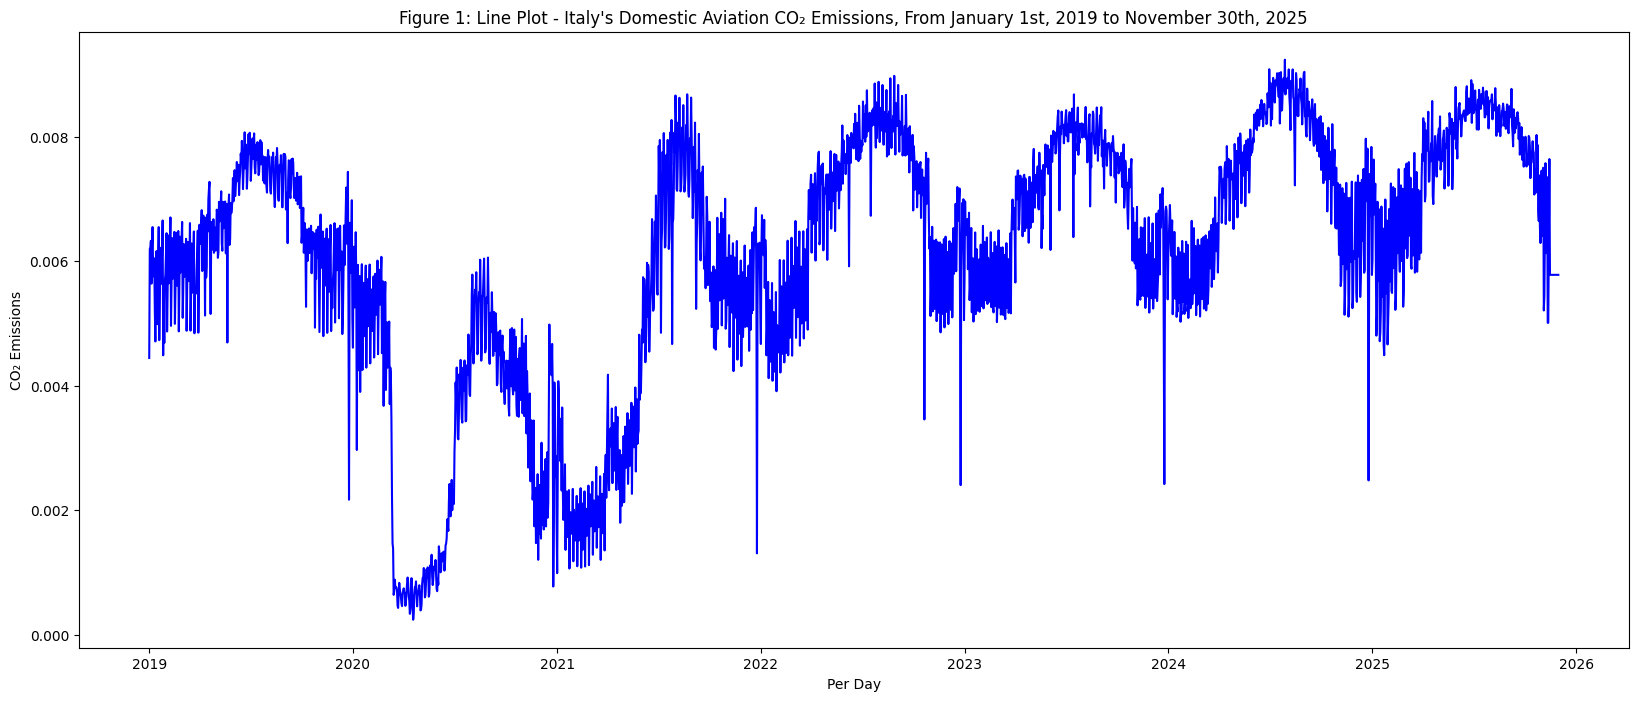

In [545]:
plt.figure(figsize=(20,8))
plt.plot(italy_domestic_aviation_df.index, italy_domestic_aviation_df['value'], color='blue')
plt.ylabel("CO₂ Emissions")
plt.xlabel('Per Day')
plt.title("Figure 1: Line Plot - Italy's Domestic Aviation CO₂ Emissions, From January 1st, 2019 to November 30th, 2025")

Text(0.5, 1.0, "Figure 2: Scatter Plot - Italy's Domestic Aviation CO₂ Emissions, From January 1st, 2019 to November 30th, 2025")

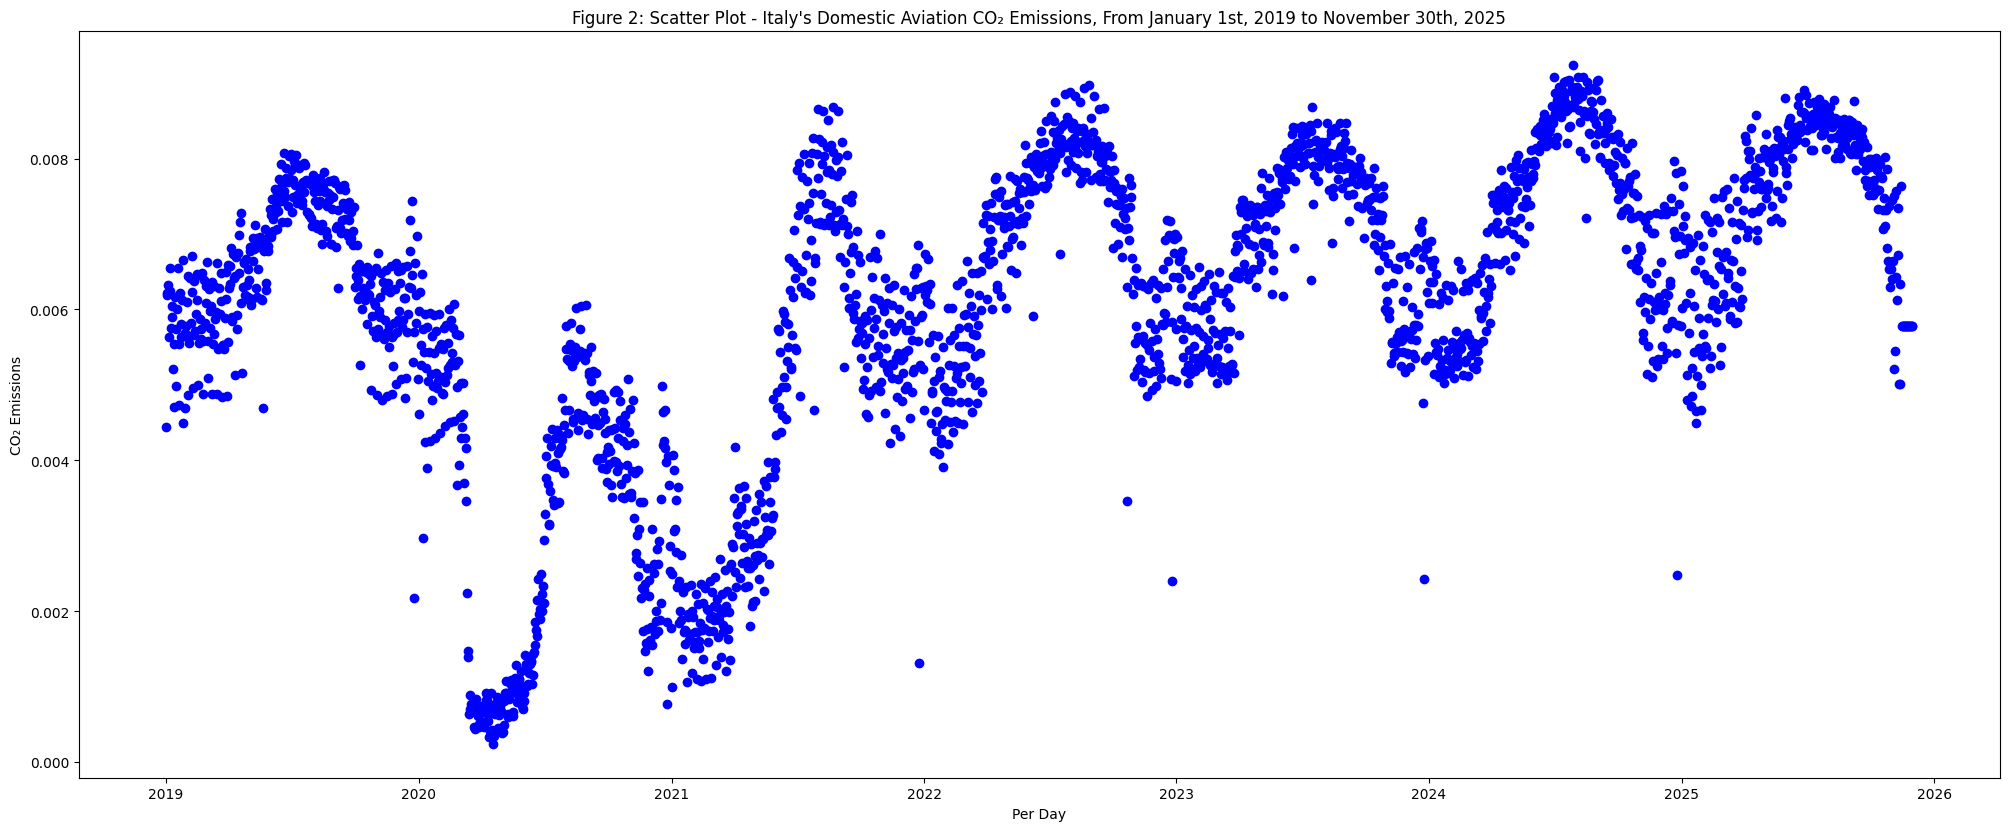

In [546]:
fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(italy_domestic_aviation_df.index, italy_domestic_aviation_df['value'], color='blue')
plt.tight_layout()
plt.ylabel("CO₂ Emissions")
plt.xlabel('Per Day')
plt.title("Figure 2: Scatter Plot - Italy's Domestic Aviation CO₂ Emissions, From January 1st, 2019 to November 30th, 2025")

In [547]:
def visualize_regime_segments(time_series,
                              change_points=None,
                              plot_title="Time Series Regime Segmentation"):

    data_series = time_series.dropna().sort_index()

    if change_points is None:
        change_points = []
    else:
        change_points = [pd.to_datetime(cp) for cp in change_points]

    valid_changes = sorted(
        [cp for cp in change_points
         if data_series.index.min() < cp < data_series.index.max()]
    )

    segment_limits = [data_series.index.min()] + valid_changes + [data_series.index.max()]

    plt.figure(figsize=(18, 6))
    plt.plot(data_series.index,
             data_series.values,
             linewidth=1,
             label="Observed Series", color="blue")

    for cp in valid_changes:
        plt.axvline(cp,
                    linestyle="--",
                    linewidth=1)

    for idx in range(len(segment_limits) - 1):

        start_date = segment_limits[idx]
        end_date   = segment_limits[idx + 1]

        segment_data = data_series.loc[
            (data_series.index >= start_date) &
            (data_series.index < end_date)
        ]

        if segment_data.empty:
            continue

        segment_mean = segment_data.mean()

        print(f"Segment Mean {idx + 1}: {segment_mean}")

        plt.hlines(segment_mean,
                   xmin=segment_data.index.min(),
                   xmax=segment_data.index.max(),
                   linewidth=3,
                   color="red",
                   label="Segment Mean" if idx == 0 else None)

    plt.title(plot_title)
    plt.xlabel("Per Day")
    plt.ylabel("CO₂ Emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [548]:
breaks = ["2020-03-01", "2022-02-01"]

Segment Mean 1: 0.006333553505882352
Segment Mean 2: 0.003912494096866097
Segment Mean 3: 0.0071102262160228896


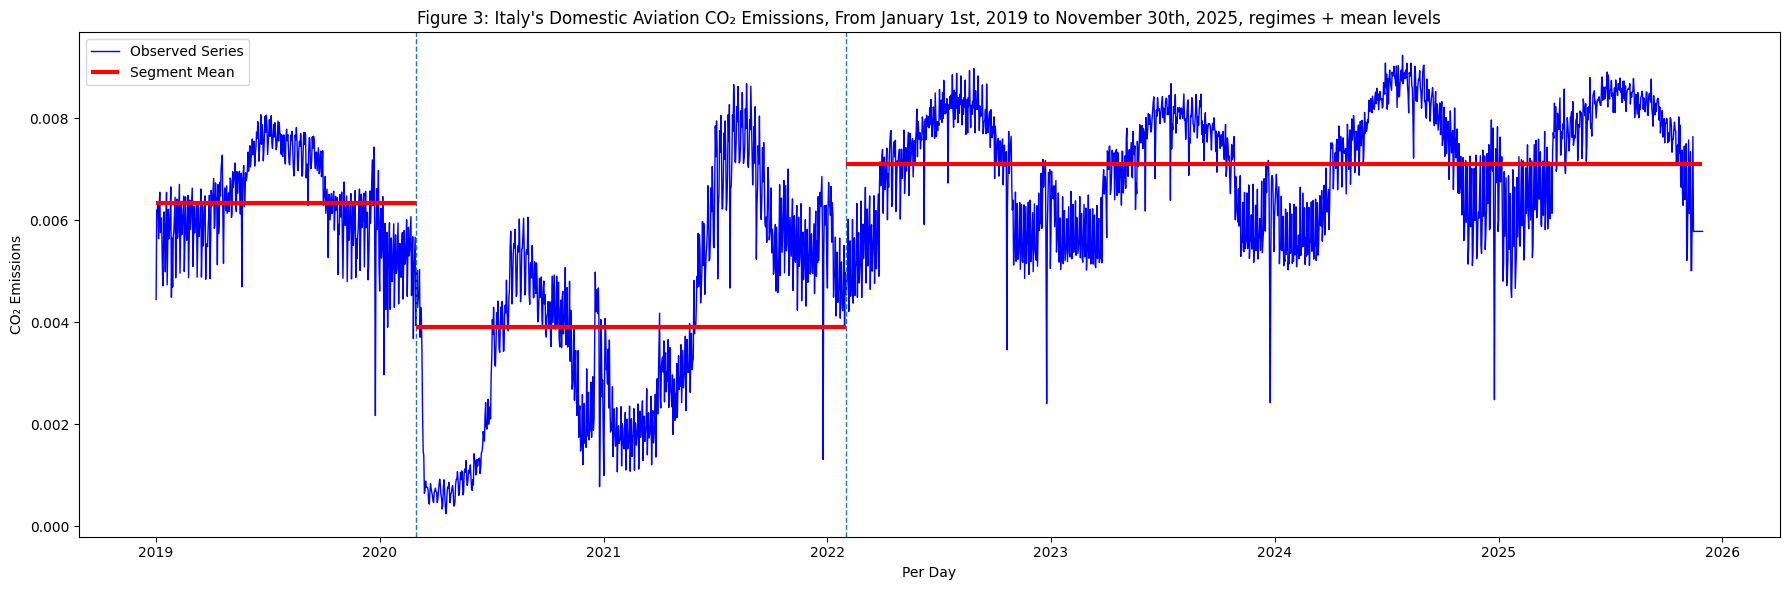

In [549]:
visualize_regime_segments(italy_domestic_aviation_df["value"], breaks, plot_title="Figure 3: Italy's Domestic Aviation CO₂ Emissions, From January 1st, 2019 to November 30th, 2025, regimes + mean levels")

In [550]:
def visualize_piecewise_linear_fit(series_input,
                                   change_dates=None,
                                   figure_title="Segmented Linear Trend"):

    cleaned_series = series_input.dropna().sort_index()

    if change_dates is None:
        change_dates = []
    else:
        change_dates = [pd.to_datetime(dt) for dt in change_dates]

    valid_points = sorted(
        [dt for dt in change_dates
         if cleaned_series.index.min() < dt < cleaned_series.index.max()]
    )

    interval_edges = [cleaned_series.index.min()] + valid_points + [cleaned_series.index.max()]

    plt.figure(figsize=(18, 6))
    plt.plot(cleaned_series.index,
             cleaned_series.values,
             linewidth=1,
             label="Observed Data",
             color="blue")

    for dt in valid_points:
        plt.axvline(dt,
                    linestyle="--",
                    linewidth=1)

    for j in range(len(interval_edges) - 1):

        start_bound = interval_edges[j]
        end_bound   = interval_edges[j + 1]

        segment_series = cleaned_series.loc[
            (cleaned_series.index >= start_bound) &
            (cleaned_series.index < end_bound)
        ]

        if len(segment_series) < 5:
            continue

        time_index = (segment_series.index - segment_series.index.min()).days.astype(float)
        values = segment_series.values.astype(float)

        slope, intercept = np.polyfit(time_index, values, 1)
        fitted_values = intercept + slope * time_index

        plt.plot(segment_series.index,
                 fitted_values,
                 linewidth=3,
                 color="green",
                 label="Segment Linear Trend" if j == 0 else None)

    plt.title(figure_title)
    plt.xlabel("Per Day")
    plt.ylabel("CO₂ Emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()

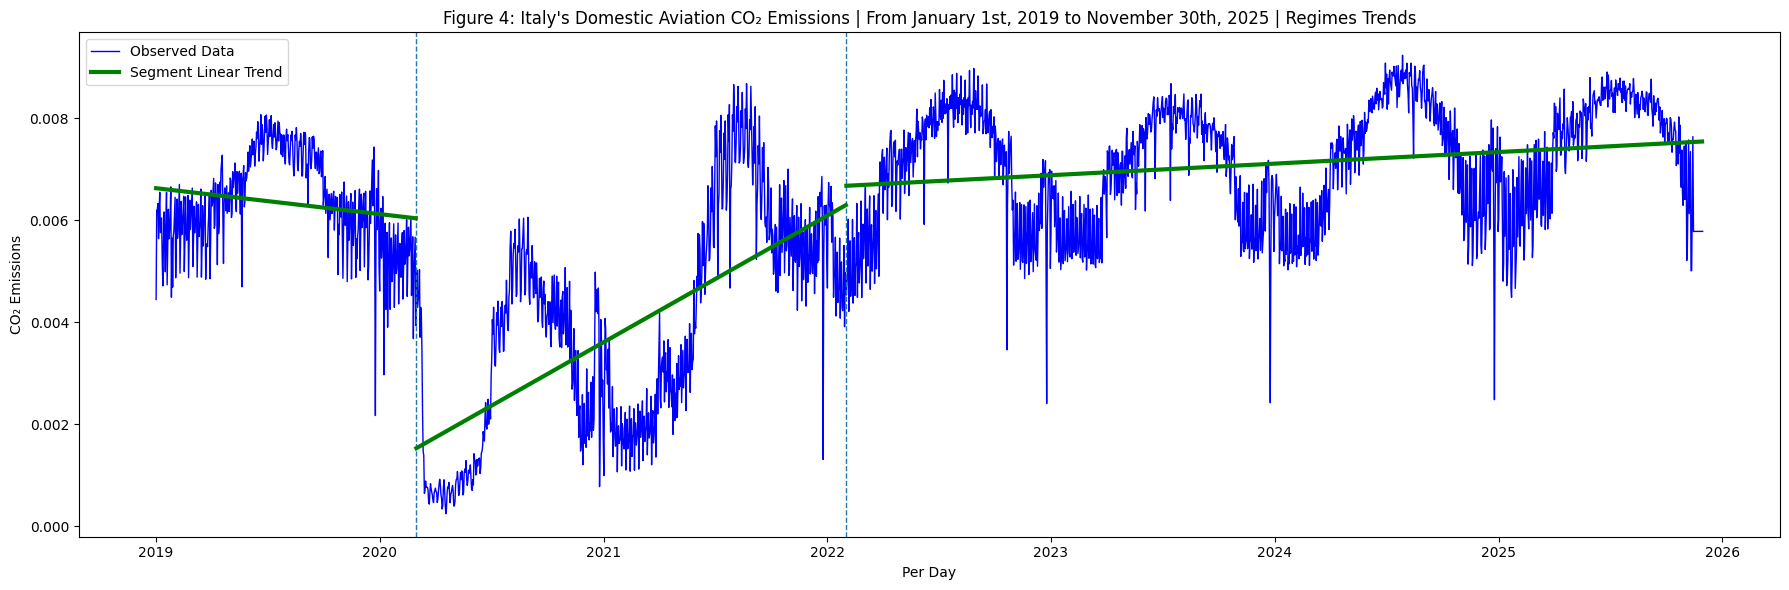

In [551]:
visualize_piecewise_linear_fit(italy_domestic_aviation_df["value"], breaks,
                     figure_title="Figure 4: Italy's Domestic Aviation CO₂ Emissions | From January 1st, 2019 to November 30th, 2025 | Regimes Trends")


In [552]:
# mean = np.mean(italy_domestic_aviation_df['value'])
# print("Median:", mean)

In [553]:
# median = np.median(italy_domestic_aviation_df['value'])
# print("Median:", median)

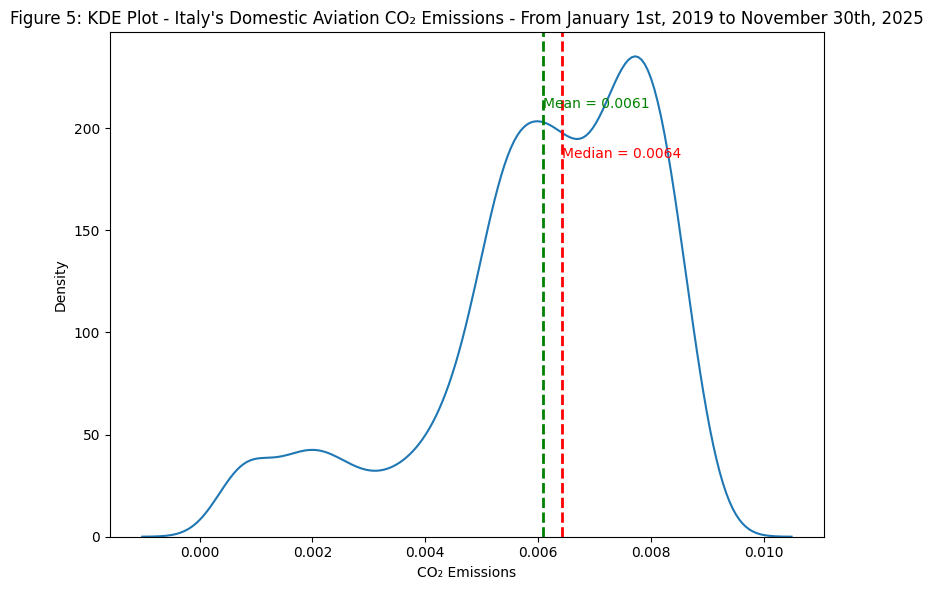

In [554]:
avg_emission = italy_domestic_aviation_df["value"].mean()
median_emission = italy_domestic_aviation_df["value"].median()

plt.figure(figsize=(8, 6))

sns.kdeplot(italy_domestic_aviation_df["value"])

plt.grid(False)

upper_density_limit = plt.ylim()[1]

plt.axvline(avg_emission,
            color="green",
            linestyle="--",
            linewidth=2)

plt.text(avg_emission,
         upper_density_limit * 0.85,
         f"Mean = {avg_emission:.4f}",
         color="green",
         ha="left")

plt.axvline(median_emission,
            color="red",
            linestyle="--",
            linewidth=2)

plt.text(median_emission,
         upper_density_limit * 0.75,
         f"Median = {median_emission:.4f}",
         color="red",
         ha="left")

plt.xlabel("CO₂ Emissions")
plt.ylabel("Density")
plt.title("Figure 5: KDE Plot - Italy's Domestic Aviation CO₂ Emissions - From January 1st, 2019 to November 30th, 2025")

plt.tight_layout()
plt.show()

In [555]:
def plot_seasonal_pattern(data_frame,
                          season_unit='year',
                          period_unit='month',
                          value_column=None,
                          plot_title = ""):

    if value_column is None:
        value_column = data_frame.columns[0]

    period_values = getattr(data_frame.index, period_unit)
    season_values = getattr(data_frame.index, season_unit)

    seasonal_table = pd.pivot_table(
        data_frame,
        index=period_values,
        columns=season_values,
        values=value_column
    )

    seasonal_table.plot(figsize=(12, 8))

    plt.title(plot_title)
    plt.xlabel("Per Month")
    plt.ylabel("CO₂ Emissions")
    plt.legend(title=season_unit.capitalize())
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

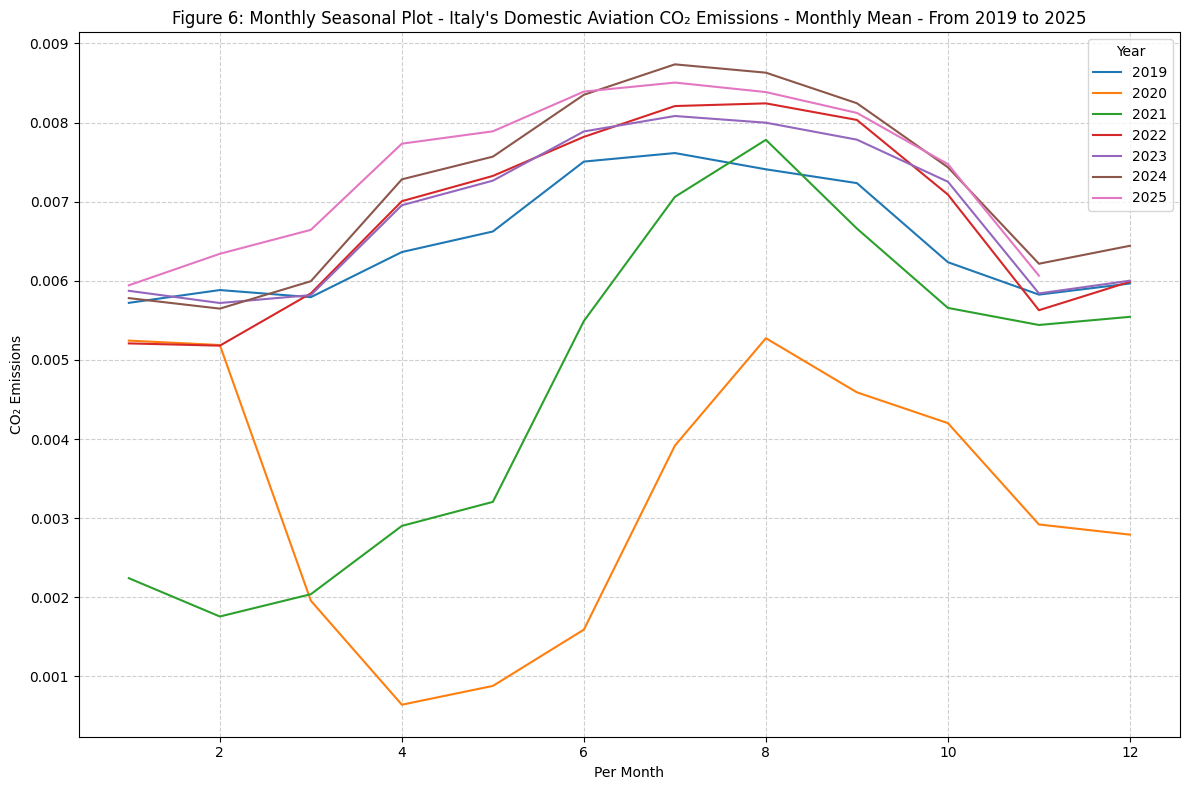

In [556]:
italy_domestic_aviation_df['year'] = italy_domestic_aviation_df.index.year
italy_domestic_aviation_df['month'] = italy_domestic_aviation_df.index.month

plot_seasonal_pattern(italy_domestic_aviation_df, season_unit='year', period_unit='month', value_column='value', plot_title="Figure 6: Monthly Seasonal Plot - Italy's Domestic Aviation CO₂ Emissions - Monthly Mean - From 2019 to 2025")

In [557]:
def monthly_subseries_visualization(input_df,
                                     month_field='month',
                                     year_field='year',
                                     emission_field='value',
                                     plot_title=""):

    monthly_summary = (
        input_df
        .groupby([month_field, year_field])[emission_field]
        .mean()
        .reset_index()
    )

    fig, subplot_array = plt.subplots(3, 4, figsize=(20, 15), sharey=True)
    subplot_array = subplot_array.flatten()
    fig.suptitle(plot_title, fontsize=16)

    month_names_list = [
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ]

    for position, month_number in enumerate(range(1, 13)):
        current_axis = subplot_array[position]

        monthly_data = monthly_summary[
            monthly_summary[month_field] == month_number
        ]

        sns.lineplot(
            x=year_field,
            y=emission_field,
            data=monthly_data,
            ax=current_axis,
            marker='o'
        )

        overall_month_avg = monthly_data[emission_field].mean()

        current_axis.axhline(
            overall_month_avg,
            color='red',
            linestyle='--',
            linewidth=1.5,
            label=f'Mean: {overall_month_avg:.3f}'
        )

        current_axis.set_title(month_names_list[month_number - 1])
        current_axis.tick_params(axis='x', rotation=45)
        current_axis.set_xlabel('Year')
        current_axis.set_ylabel('CO₂ Emissions')
        current_axis.grid(True, linestyle='--', alpha=0.6)
        current_axis.legend()

    plt.tight_layout()
    plt.show()

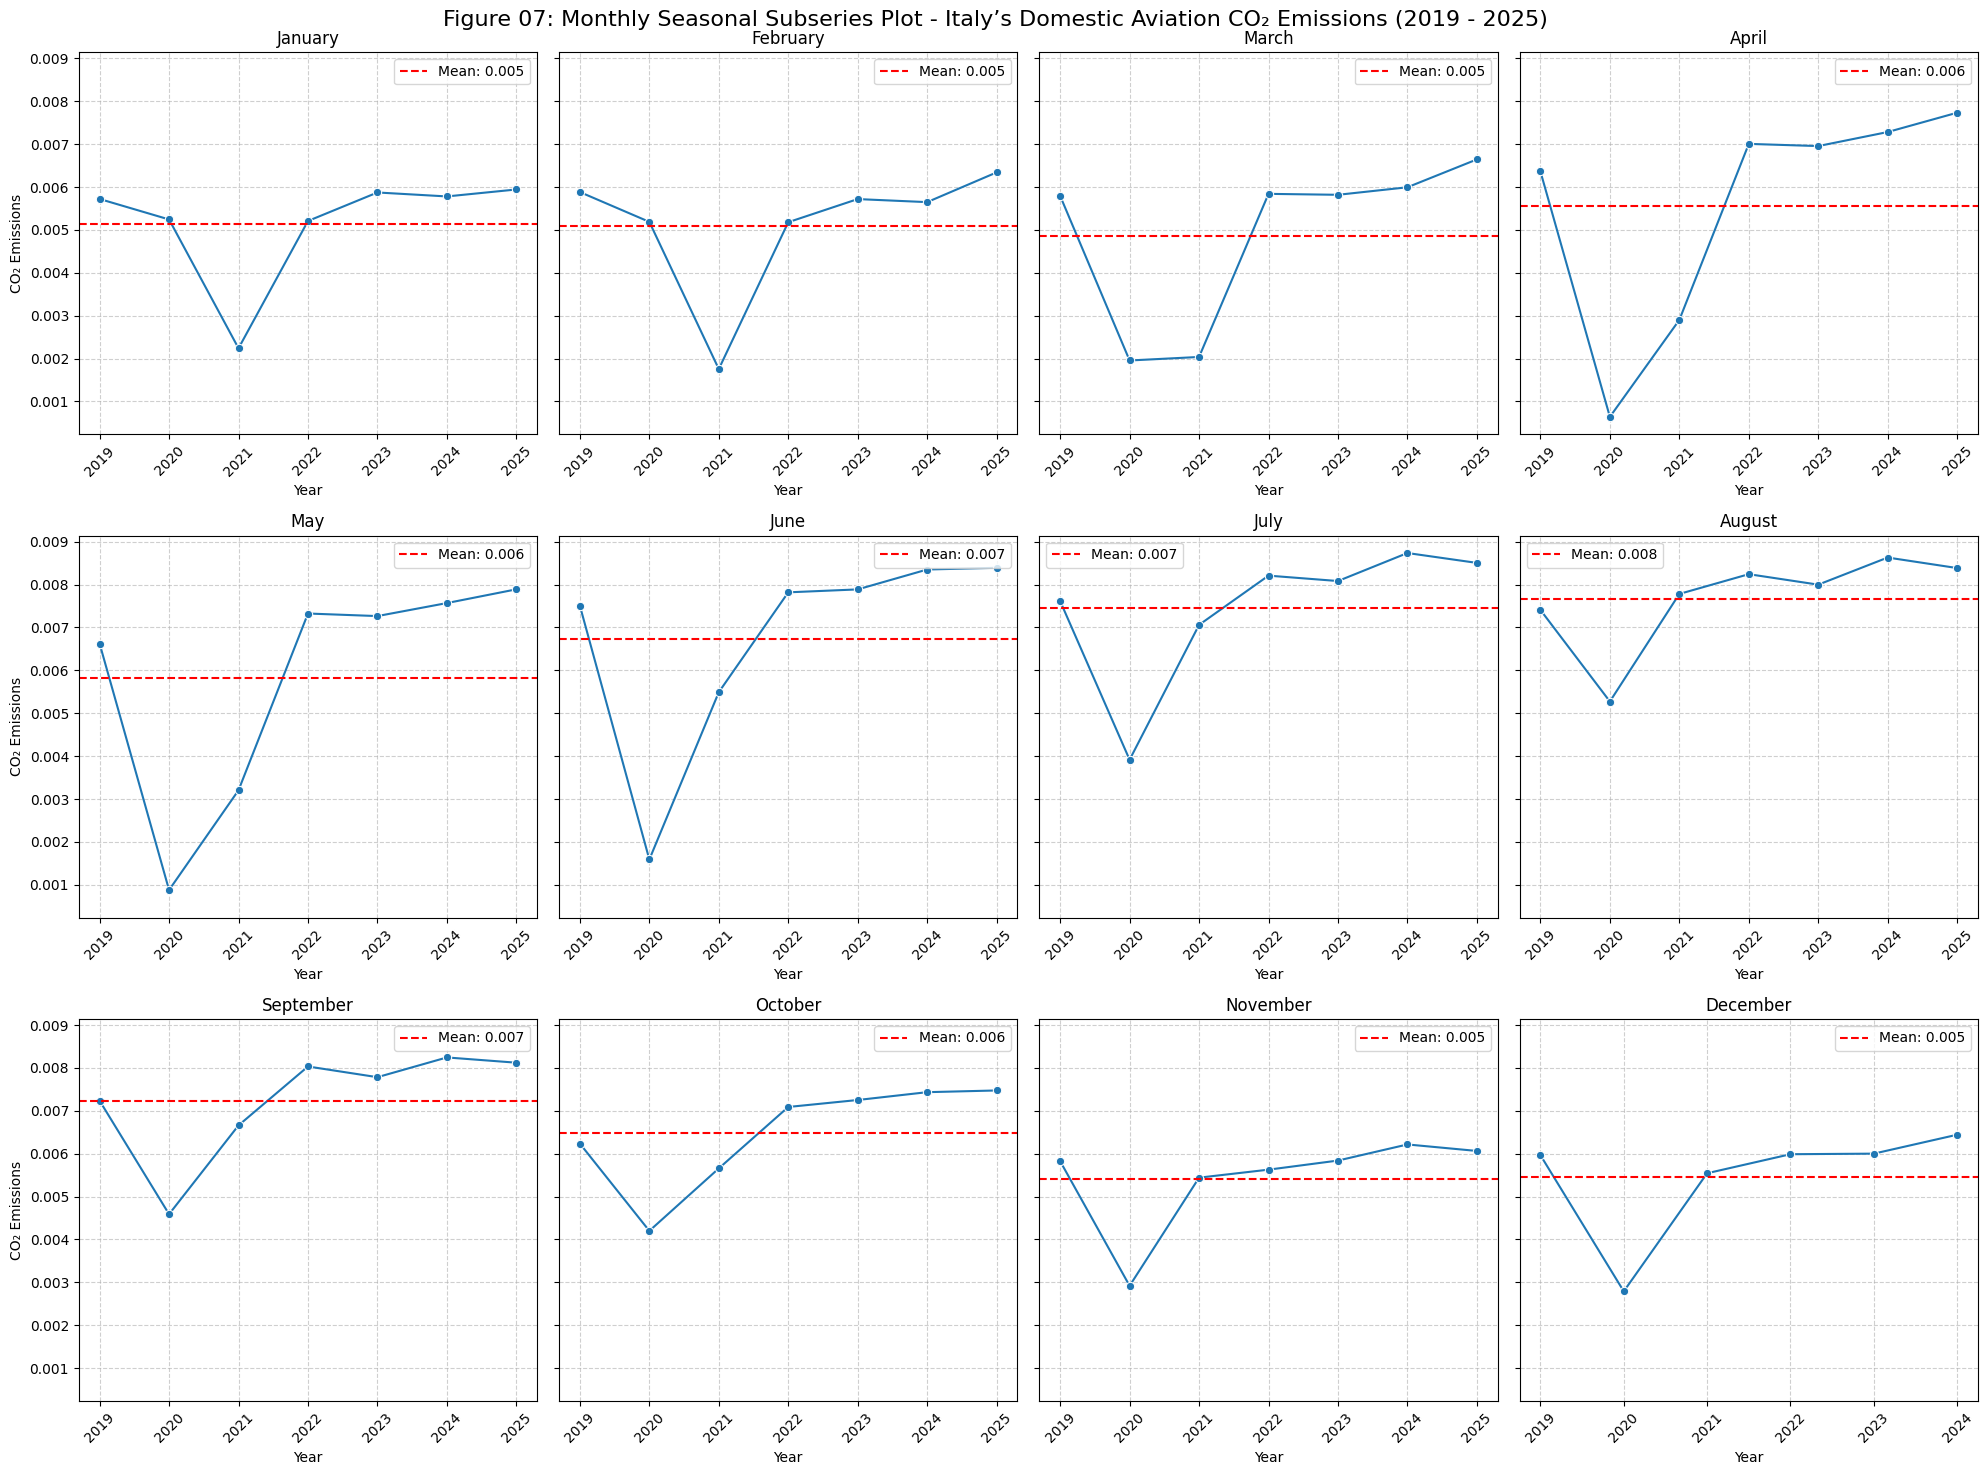

In [558]:
monthly_subseries_visualization(
    italy_domestic_aviation_df,
    month_field='month',
    year_field='year',
    emission_field='value',
    plot_title="Figure 07: Monthly Seasonal Subseries Plot - Italy’s Domestic Aviation CO₂ Emissions (2019 - 2025)"
)

In [559]:
display(len(italy_domestic_aviation_df))

2526

In [560]:
num_of_lags = round(np.sqrt(len(italy_domestic_aviation_df)))
display(num_of_lags)

50

In [561]:
ci_limit = 1.96 / np.sqrt(len(italy_domestic_aviation_df))
display(ci_limit, -ci_limit)

np.float64(0.03899773629664761)

np.float64(-0.03899773629664761)

In [562]:
def visualize_acf_with_fixed_bounds(data_series,
                                    lag_count=50,
                                    plot_heading="Autocorrelation Function (ACF)",
                                    conf_level=0.95):

    cleaned_series = data_series.dropna()

    total_obs = len(cleaned_series)

    if conf_level == 0.95:
        critical_z = 1.96
    elif conf_level == 0.99:
        critical_z = 2.576
    elif conf_level == 0.90:
        critical_z = 1.645
    else:
        raise ValueError("Allowed confidence levels: 0.90, 0.95, 0.99")

    bound_limit = critical_z / np.sqrt(total_obs)

    fig_container, axis_container = plt.subplots(figsize=(16, 8))

    plot_acf(
        cleaned_series,
        lags=lag_count,
        alpha=None,
        ax=axis_container
    )

    axis_container.axhline(bound_limit,
                           color='red',
                           linestyle='--',
                           linewidth=1.5,
                           label=f'+{int(conf_level*100)}% CI ({bound_limit:.3f})')

    axis_container.axhline(-bound_limit,
                           color='red',
                           linestyle='--',
                           linewidth=1.5,
                           label=f'-{int(conf_level*100)}% CI ({-bound_limit:.3f})')

    axis_container.set_title(plot_heading)
    axis_container.set_ylim(-1.05, 1.05)
    axis_container.legend()

    plt.tight_layout()
    plt.show()

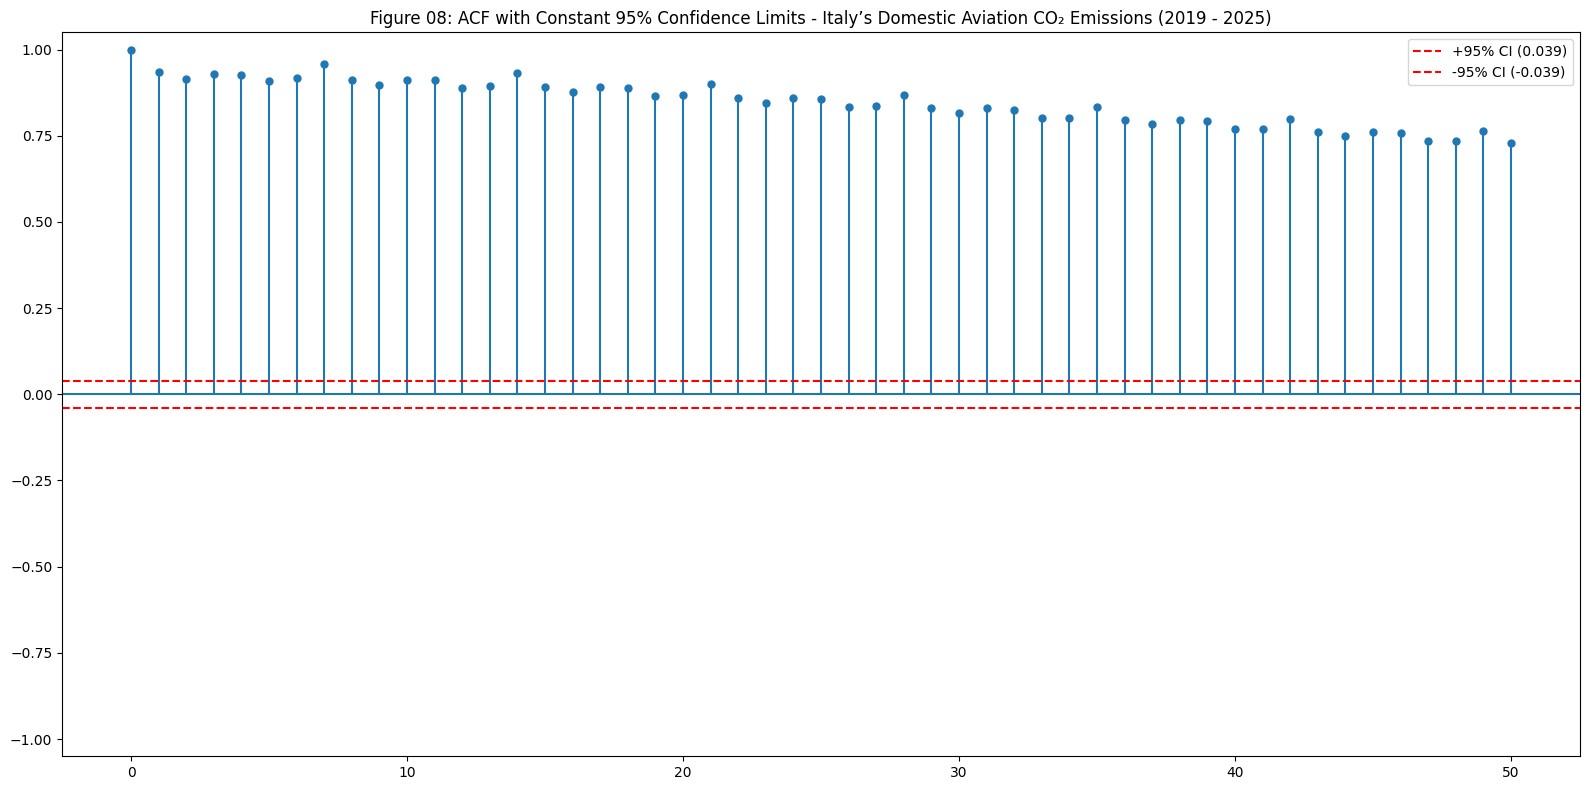

In [563]:
visualize_acf_with_fixed_bounds(
    italy_domestic_aviation_df["value"],
    lag_count=num_of_lags,
    plot_heading="Figure 08: ACF with Constant 95% Confidence Limits - Italy’s Domestic Aviation CO₂ Emissions (2019 - 2025)",
    conf_level=0.95
)

In [564]:
def visualize_time_series_with_moving_statistics(data_frame,
                                                  target_column="value",
                                                  moving_window=52,
                                                  figure_title="Rolling Statistics",
                                                  y_axis_label="CO₂ Emissions",
                                                  x_axis_label="Per Day",
                                                  figure_dimensions=(15, 8),
                                                  display_series=True,
                                                  display_mean=True,
                                                  display_std=True):

    cleaned_values = data_frame[target_column].dropna()

    fig_canvas, axis_canvas = plt.subplots(nrows=1, ncols=1, figsize=figure_dimensions)

    if display_series:
        sns.lineplot(
            x=cleaned_values.index,
            y=cleaned_values.values,
            ax=axis_canvas,
            color="blue",
            label="Observed Values"
        )

    if display_mean:
        moving_average = cleaned_values.rolling(moving_window).mean()
        sns.lineplot(
            x=moving_average.index,
            y=moving_average.values,
            ax=axis_canvas,
            color="red",
            label=f"Moving Average (Window={moving_window})"
        )

    if display_std:
        moving_std_dev = cleaned_values.rolling(moving_window).std()
        sns.lineplot(
            x=moving_std_dev.index,
            y=moving_std_dev.values,
            ax=axis_canvas,
            color="green",
            label=f"Moving Std Dev (Window={moving_window})"
        )

    axis_canvas.set_title(figure_title, fontsize=14)
    axis_canvas.set_ylabel(y_axis_label, fontsize=14)
    axis_canvas.set_xlabel(x_axis_label, fontsize=14)
    axis_canvas.legend()

    axis_canvas.set_xlim([cleaned_values.index.min(),
                          cleaned_values.index.max()])

    plt.tight_layout()
    plt.show()

In [565]:
moving_window = round(len(italy_domestic_aviation_df) * 10 / 100)
display(moving_window)

253

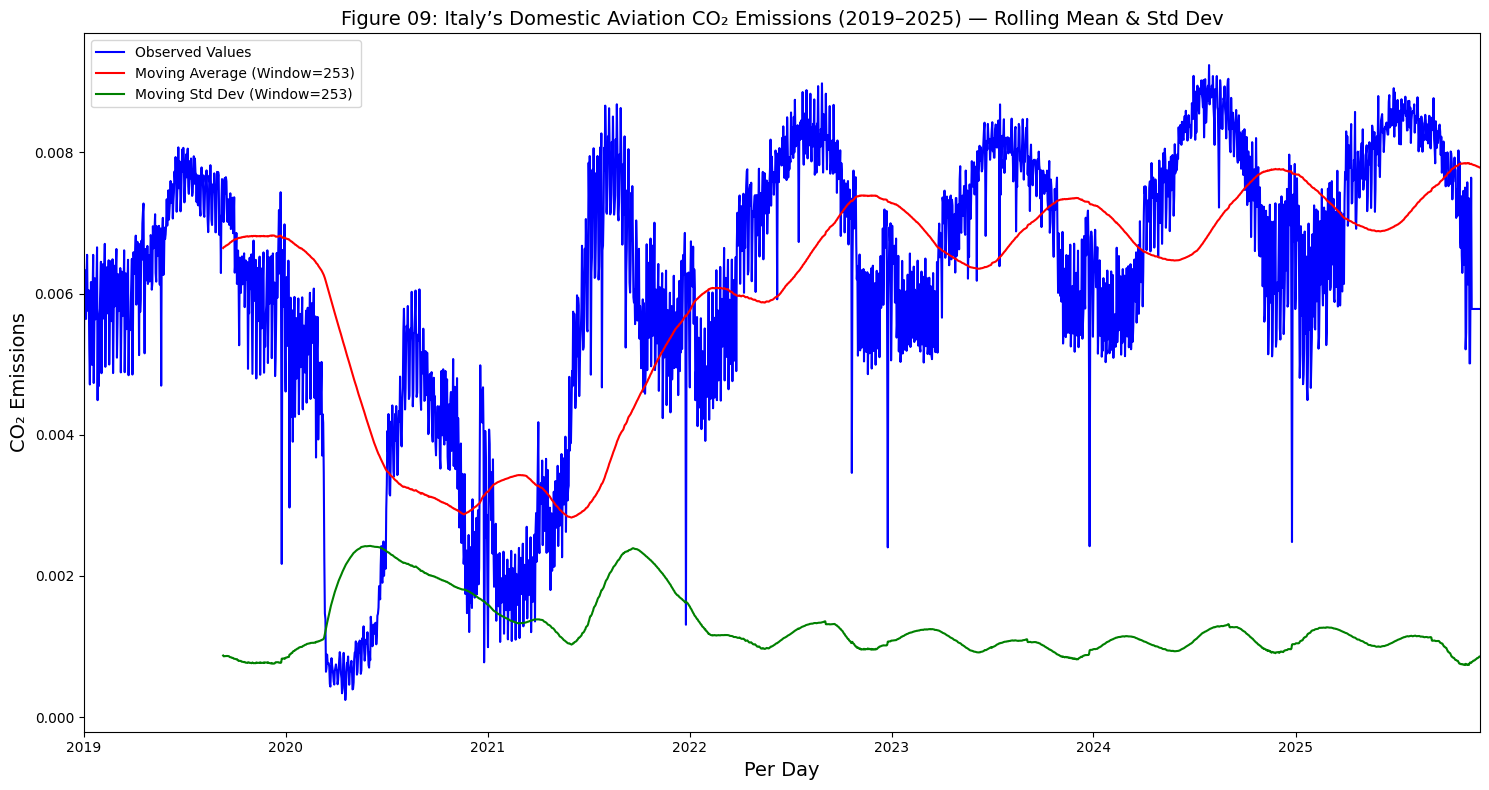

In [566]:
visualize_time_series_with_moving_statistics(
    data_frame=italy_domestic_aviation_df,
    target_column="value",
    moving_window=moving_window,
    figure_title="Figure 09: Italy’s Domestic Aviation CO₂ Emissions (2019–2025) — Rolling Mean & Std Dev"
)

In [567]:
def custom_boxplot_layout(data_frame,
                            feature_name="value",
                            main_title="Box Plot",
                            vertical_label="CO₂ Emissions",
                            canvas_size=(10, 7),
                            fill_color="#BFDCE5"):

    observations = data_frame[feature_name].dropna().to_numpy(dtype=float)

    if observations.size == 0:
        raise ValueError(f"No valid values found in column '{feature_name}'.")

    p25 = np.percentile(observations, 25)
    p50 = np.percentile(observations, 50)
    p75 = np.percentile(observations, 75)
    interquartile_span = p75 - p25

    lower_limit = p25 - 1.5 * interquartile_span
    upper_limit = p75 + 1.5 * interquartile_span

    whisker_min = np.min(observations[observations >= lower_limit])
    whisker_max = np.max(observations[observations <= upper_limit])

    extreme_low  = observations[observations < lower_limit]
    extreme_high = observations[observations > upper_limit]

    anomaly_total = extreme_low.size + extreme_high.size
    anomaly_ratio = 100.0 * anomaly_total / observations.size

    percent_below_p25 = 100.0 * np.mean(observations < p25)
    percent_above_p75 = 100.0 * np.mean(observations > p75)
    percent_below_p75 = 100.0 * np.mean(observations < p75)
    percent_middle    = 100.0 * np.mean((observations >= p25) & (observations <= p75))

    value_range = observations.max() - observations.min()
    offset = value_range * 0.07 if value_range > 0 else 1e-6

    fig_obj, axis_obj = plt.subplots(figsize=canvas_size)

    sns.boxplot(
        y=observations,
        ax=axis_obj,
        color=fill_color,
        width=0.35,
        linewidth=1,
        medianprops=dict(color='blue', linewidth=2),
        meanprops=dict(color='green', linewidth=2),
        flierprops=dict(
            marker='o',
            markerfacecolor='red',
            markeredgecolor='red',
            markersize=5,
            alpha=0.8
        )
    )

    axis_obj.set_title(main_title, fontsize=14, pad=18)
    axis_obj.set_ylabel(vertical_label, fontsize=12)
    axis_obj.set_xticks([])
    axis_obj.grid(axis="y", linestyle="--", alpha=0.25)

    summary_line = (
        f"Outliers: {anomaly_total} ({anomaly_ratio:.2f}%) | "
        f"Lower: {extreme_low.size} | Upper: {extreme_high.size}"
    )

    fig_obj.text(0.5, 0.93,
                 summary_line,
                 ha="center",
                 va="center",
                 fontsize=11,
                 color="red",
                 fontweight="bold")

    axis_obj.set_ylim(observations.min() - offset * 2.0,
                      observations.max() + offset * 3.0)

    axis_obj.text(0,
                  p50 + offset * 0.50,
                  f"Median (Q2) = {p50:.4f}",
                  ha="center",
                  va="center",
                  fontsize=11,
                  color="blue",
                  fontweight="bold")

    axis_obj.text(0,
                  p50 - offset * 0.80,
                  f"IQR = {interquartile_span:.4f}\n{percent_middle:.1f}% inside IQR",
                  ha="center",
                  va="center",
                  fontsize=10)

    def side_annotation(y_point, text_label, x_position, y_position):
        axis_obj.annotate(
            text_label,
            xy=(0, y_point),
            xytext=(x_position, y_position),
            textcoords="data",
            ha="left" if x_position > 0 else "right",
            va="center",
            fontsize=10,
            arrowprops=dict(
                arrowstyle="-",
                lw=1,
                color="orange",
                connectionstyle="angle3,angleA=0,angleB=90"
            ),
        )

    right_anchor = 0.22
    left_anchor  = -0.22

    side_annotation(p75,
                    f"Q3 = {p75:.4f}\n{percent_below_p75:.1f}% below Q3",
                    right_anchor,
                    p75 + offset * 0.50)

    side_annotation(p25,
                    f"Q1 = {p25:.4f}\n{percent_below_p25:.1f}% below Q1",
                    right_anchor,
                    p25 - offset * 0.50)

    side_annotation(whisker_max,
                    f"Upper whisker = {whisker_max:.4f}",
                    left_anchor,
                    whisker_max + offset * 0.25)

    side_annotation(whisker_min,
                    f"Lower whisker = {whisker_min:.4f}",
                    left_anchor,
                    whisker_min - offset * 0.25)

    if extreme_low.size > 0:
        lowest_outlier_value = extreme_low.min()

        axis_obj.annotate(
            f"Lower outliers = {extreme_low.size}",
            xy=(0, lowest_outlier_value),
            xytext=(-0.28, lowest_outlier_value - offset * 0.8),
            textcoords="data",
            ha="right",
            va="center",
            fontsize=10,
            color="black",
            arrowprops=dict(
                arrowstyle="-",
                lw=1,
                color="orange",
                connectionstyle="angle3,angleA=0,angleB=90"
            ),
        )

    if extreme_high.size > 0:
        highest_outlier_value = extreme_high.max()

        axis_obj.annotate(
            f"Upper outliers = {extreme_high.size}",
            xy=(0, highest_outlier_value),
            xytext=(0.28, highest_outlier_value + offset * 0.8),
            textcoords="data",
            ha="left",
            va="center",
            fontsize=10,
            color="black",
            arrowprops=dict(
                arrowstyle="-",
                lw=1,
                color="orange",
                connectionstyle="angle3,angleA=0,angleB=90"
            ),
        )

    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()

    return {
        "Q1": p25,
        "Median": p50,
        "Q3": p75,
        "IQR": interquartile_span,
        "LowerWhisker": whisker_min,
        "UpperWhisker": whisker_max,
        "OutliersTotal": anomaly_total,
        "OutlierPercent": anomaly_ratio
    }

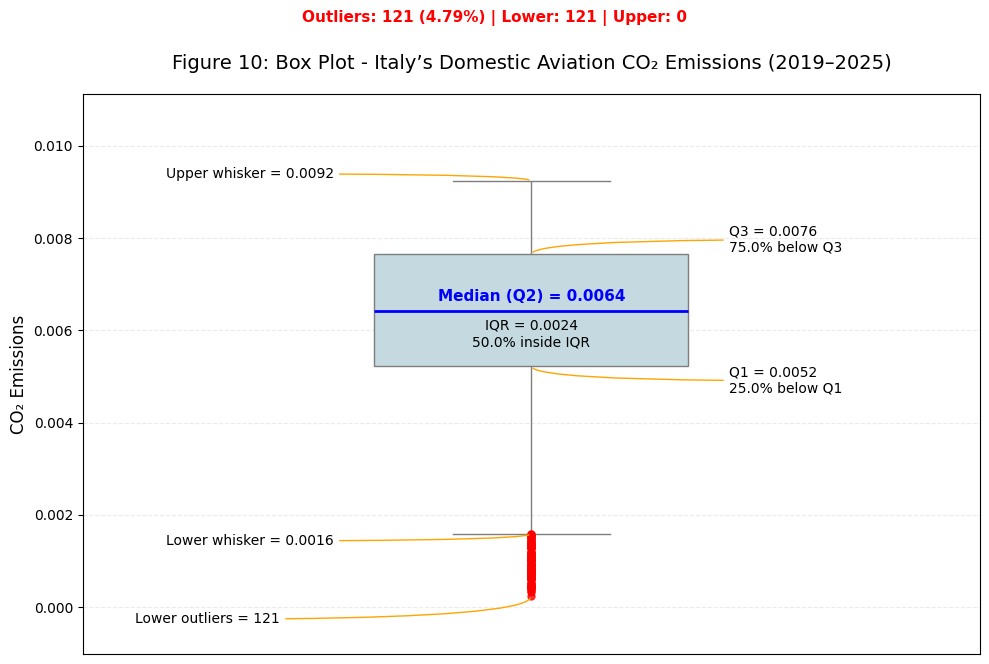

{'Q1': np.float64(0.0052255675),
 'Median': np.float64(0.006423655),
 'Q3': np.float64(0.0076482975),
 'IQR': np.float64(0.0024227299999999997),
 'LowerWhisker': np.float64(0.00159301),
 'UpperWhisker': np.float64(0.00923652),
 'OutliersTotal': 121,
 'OutlierPercent': 4.790182106096595}

In [568]:
custom_boxplot_layout(
    italy_domestic_aviation_df,
    feature_name="value",
    main_title="Figure 10: Box Plot - Italy’s Domestic Aviation CO₂ Emissions (2019–2025)"
)

In [569]:
italy_domestic_aviation_df['value'].describe()

,value
count,2526.000000
mean,0.006090
std,0.002010
min,0.000241
25%,0.005226
50%,0.006424
75%,0.007648
max,0.009237


In [570]:
def run_isolation_forest_detection(
    input_dataframe,
    target_feature="value",
    num_trees=100,
    sample_limit=256,
    anomaly_fraction=0.10,
    seed_value=42,
    max_tree_height=6,
    display_plot=True,
    figure_caption=""
):

    processed_df = input_dataframe.copy().sort_index()

    iso_model = IsolationForest(
        n_estimators=num_trees,
        max_samples=sample_limit,
        contamination=anomaly_fraction,
        random_state=seed_value
    )

    processed_df["anomaly"] = iso_model.fit_predict(
        processed_df[[target_feature]]
    )

    processed_df["anomaly_score"] = iso_model.decision_function(
        processed_df[[target_feature]]
    )

    processed_df["is_anomaly"] = processed_df["anomaly"] == -1

    detected_points = processed_df[processed_df["is_anomaly"]]
    anomaly_percentage = (len(detected_points) / len(processed_df)) * 100

    print(
        f"Isolation Forest detected {len(detected_points)} anomalies "
        f"({anomaly_percentage:.2f}% of total observations).\n"
    )

    return processed_df, anomaly_percentage

In [571]:
tree_count = 100
max_sample_size = round(0.1 * len(italy_domestic_aviation_df))
display(max_sample_size)

253

In [572]:
max_tree_height = round(np.log2(max_sample_size))
display(max_tree_height)

8

In [573]:
contamination_rate = 0.05

In [574]:
df_isolation_forest_output, anomaly_ratio = run_isolation_forest_detection(
    italy_domestic_aviation_df,
    target_feature="value",
    num_trees=tree_count,
    sample_limit=max_sample_size,
    anomaly_fraction=contamination_rate
)

Isolation Forest detected 126 anomalies (4.99% of total observations).



In [575]:
display(df_isolation_forest_output[df_isolation_forest_output['is_anomaly'] == True][['value','anomaly','anomaly_score','is_anomaly']].head())

,value,anomaly,anomaly_score,is_anomaly
date,,,,
2020-03-14,0.000641,-1,-0.017242,True
2020-03-15,0.000698,-1,-0.011017,True
2020-03-16,0.000885,-1,-0.012115,True
2020-03-17,0.000768,-1,-0.010035,True
2020-03-18,0.000760,-1,-0.009603,True


In [576]:
def visualize_anomaly_scores(
    input_df,
    score_column="anomaly_score",
    label_column="anomaly",
    time_axis=None,
    figure_title="Isolation Forest Anomaly Score Visualization",
    canvas_dim=(10, 5)
):

    data_copy = input_df.copy()

    if time_axis is None:
        time_axis = data_copy.index

    regular_points = data_copy[data_copy[label_column] == 1]

    abnormal_points = data_copy[data_copy[label_column] == -1]

    plt.figure(figsize=canvas_dim)

    plt.scatter(
        regular_points.index,
        regular_points[score_column],
        color="blue",
        label="Regular Observations",
        alpha=0.7
    )

    plt.scatter(
        abnormal_points.index,
        abnormal_points[score_column],
        color="red",
        label="Detected Anomalies",
        alpha=0.9
    )

    plt.axhline(0, linestyle="--", linewidth=1, color="black", alpha=0.6)

    plt.xlabel("Instances (CO2 Emissions)")
    plt.ylabel("Anamoly Score")
    plt.title(figure_title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

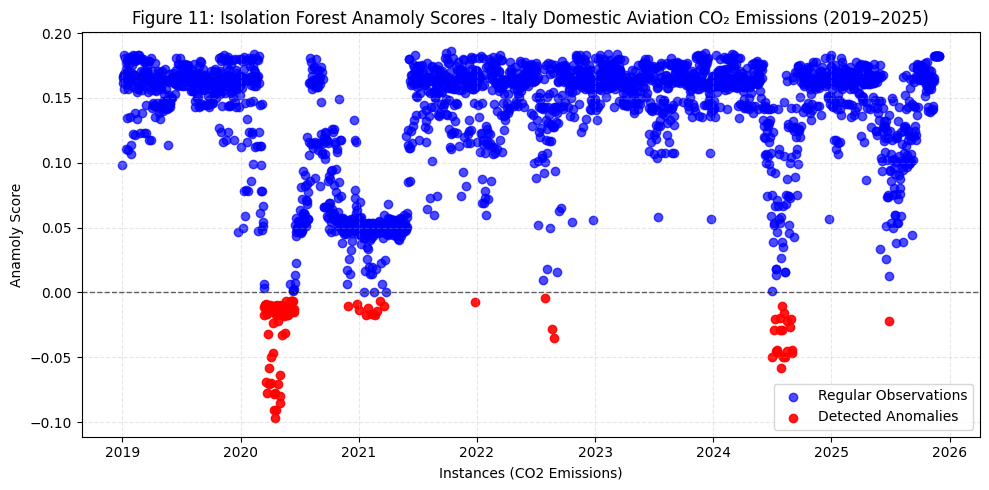

In [577]:
visualize_anomaly_scores(
    df_isolation_forest_output,
    score_column="anomaly_score",
    label_column="anomaly",
    figure_title="Figure 11: Isolation Forest Anamoly Scores - Italy Domestic Aviation CO₂ Emissions (2019–2025)"
)

In [578]:
def _ols_slope_1d(arr: np.ndarray) -> float:
    arr = np.asarray(arr, dtype=np.float64)
    if arr.size < 2:
        return 0.0
    t = np.arange(arr.size, dtype=np.float64)
    m, _ = np.polyfit(t, arr, 1)
    return float(m)

def _cohens_d(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    n1, n2 = a.size, b.size
    if n1 < 2 or n2 < 2:
        return 0.0
    s1 = a.std(ddof=1)
    s2 = b.std(ddof=1)
    pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / max(n1 + n2 - 2, 1))
    if pooled < 1e-12:
        return 0.0
    return float((b.mean() - a.mean()) / pooled)

def _window_stack(series_2d: np.ndarray, win: int) -> np.ndarray:
    blocks = []
    for i in range(win - 1, len(series_2d)):
        blocks.append(series_2d[i - win + 1 : i + 1])
    return np.stack(blocks, axis=0)

def _label_break_kind(
    raw_series: pd.Series,
    change_time: pd.Timestamp,
    left_days: int,
    right_days: int,
    mean_d_thr: float,
    slope_rel_thr: float,
    var_ratio_thr: float,
):
    left = raw_series.loc[change_time - pd.Timedelta(days=left_days) : change_time - pd.Timedelta(days=1)]
    right = raw_series.loc[change_time : change_time + pd.Timedelta(days=right_days)]

    if len(left) < max(10, left_days // 3) or len(right) < max(10, right_days // 3):
        return {"break_date": change_time, "break_label": "unclear", "details": {"reason": "insufficient pre/post samples"}}

    a = left.values
    b = right.values

    d = _cohens_d(a, b)

    m1 = _ols_slope_1d(a)
    m2 = _ols_slope_1d(b)
    rel_slope = abs(m2 - m1) / (abs(m1) + 1e-12)

    v1 = float(np.var(a, ddof=1))
    v2 = float(np.var(b, ddof=1))
    if v1 < 1e-12 or v2 < 1e-12:
        vr = 1.0
    else:
        vr = max(v2 / v1, v1 / v2)

    is_level = abs(d) >= mean_d_thr
    is_trend = rel_slope >= slope_rel_thr
    is_vol = vr >= var_ratio_thr

    active = []
    if is_level: active.append("level")
    if is_trend: active.append("trend")
    if is_vol:   active.append("volatility")

    if len(active) == 0:
        lbl = "unclear"
    elif len(active) == 1:
        lbl = active[0]
    else:
        lbl = "mixed"

    return {
        "break_date": change_time,
        "break_label": lbl,
        "details": {
            "cohen_d_mean_shift": d,
            "slope_pre": m1,
            "slope_post": m2,
            "slope_rel_change": rel_slope,
            "var_pre": v1,
            "var_post": v2,
            "var_ratio": vr,
            "pre_mean": float(np.mean(a)),
            "post_mean": float(np.mean(b)),
        },
    }

class SeqAutoencoder(nn.Module):
    def __init__(self, in_dim: int = 1, hid_dim: int = 64):
        super().__init__()
        self.enc = nn.LSTM(in_dim, hid_dim, batch_first=True)
        self.dec = nn.LSTM(hid_dim, hid_dim, batch_first=True)
        self.proj = nn.Linear(hid_dim, in_dim)

    def forward(self, x):
        _, (h, _) = self.enc(x)
        h_last = h[-1]
        dec_in = h_last.unsqueeze(1).repeat(1, x.size(1), 1)
        z, _ = self.dec(dec_in)
        return self.proj(z)

def detect_breaks_single_baseline_stl(
    df_in: pd.DataFrame,
    value_col: str = "value",
    baseline_end: str = "2020-03-01",

    seasonal_adjust: bool = True,
    stl_period: int = 365,
    stl_robust: bool = True,

    seq_len: int = 30,
    hidden_dim: int = 64,
    n_epochs: int = 40,
    batch_sz: int = 128,
    learn_rate: float = 0.001,
    seed: int = 42,

    smooth_win: int = 7,
    z_cut: float = 3.0,
    min_streak: int = 7,

    pre_days: int = 60,
    post_days: int = 60,
    mean_d_thr: float = 0.8,
    slope_rel_thr: float = 1.0,
    var_ratio_thr: float = 2.0,

    make_plots: bool = True,
):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    data = df_in.copy().sort_index().asfreq("D")
    data[value_col] = pd.to_numeric(data[value_col], errors="coerce")
    data[value_col] = data[value_col].replace([np.inf, -np.inf], np.nan).ffill().bfill()

    idx = data.index
    raw = pd.Series(data[value_col].values.astype(np.float64), index=idx, name=value_col)

    if seasonal_adjust:
        stl = STL(raw, period=stl_period, robust=stl_robust)
        stl_fit = stl.fit()
        seasonal = stl_fit.seasonal
        trend = stl_fit.trend
        detect_series = raw - seasonal
    else:
        seasonal = pd.Series(np.zeros(len(raw)), index=idx)
        trend = pd.Series(np.zeros(len(raw)), index=idx)
        detect_series = raw.copy()

    base_end = pd.to_datetime(baseline_end)
    base_mask = idx <= base_end
    if base_mask.sum() < (seq_len + 60):
        raise ValueError(
            f"Not enough baseline points <= {baseline_end}. "
            f"Need at least ~{seq_len+60}, got {base_mask.sum()}."
        )

    y2d = detect_series.values.reshape(-1, 1).astype(np.float64)
    scaler = StandardScaler()
    scaler.fit(y2d[base_mask])
    y_scaled = scaler.transform(y2d)

    X_all = _window_stack(y_scaled, seq_len)
    end_idx = idx[seq_len - 1 :]
    X_base = X_all[end_idx <= base_end]
    X_base_t = torch.tensor(X_base, dtype=torch.float32)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = SeqAutoencoder(in_dim=1, hid_dim=hidden_dim).to(device)

    opt = torch.optim.Adam(net.parameters(), lr=learn_rate)
    crit = nn.MSELoss()
    loader = DataLoader(TensorDataset(X_base_t, X_base_t), batch_size=batch_sz, shuffle=True)

    net.train()
    for ep in range(1, n_epochs + 1):
        losses = []
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = net(xb)
            loss = crit(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            opt.step()
            losses.append(loss.item())
        if ep < n_epochs or ep == n_epochs:
            print(f"Epoch {ep:02d}/{n_epochs} - train MSE: {float(np.mean(losses)):.6f}")

    net.eval()
    X_all_t = torch.tensor(X_all, dtype=torch.float32).to(device)
    with torch.no_grad():
        recon = net(X_all_t).cpu().numpy()

    mse = np.mean((recon - X_all) ** 2, axis=(1, 2))
    mse_s = pd.Series(mse, index=end_idx, name="recon_mse")
    mse_sm = mse_s.rolling(smooth_win, center=True).mean().bfill().ffill()

    base_err = mse_sm[mse_sm.index <= base_end]
    mu = base_err.mean()
    sd = base_err.std(ddof=1)
    z = (mse_sm - mu) / (sd + 1e-12)

    high = z > z_cut
    streak = (high.astype(int).rolling(min_streak).sum().ge(min_streak)).fillna(False)

    break_dates = []
    in_run = False
    for t, flag in streak.items():
        if flag and not in_run:
            start_t = t - pd.Timedelta(days=min_streak - 1)
            break_dates.append(start_t)
            in_run = True
        elif (not flag) and in_run:
            in_run = False

    rows = []
    for bd in break_dates:
        r = _label_break_kind(
            raw_series=raw,
            change_time=bd,
            left_days=pre_days,
            right_days=post_days,
            mean_d_thr=mean_d_thr,
            slope_rel_thr=slope_rel_thr,
            var_ratio_thr=var_ratio_thr,
        )
        row = {"break_date": r["break_date"], "break_label": r["break_label"]}
        row.update(r.get("details", {}))
        rows.append(row)

    breaks_df = pd.DataFrame(rows).sort_values("break_date").reset_index(drop=True)
    err_df = pd.DataFrame({"recon_mse": mse_s, "recon_mse_smooth": mse_sm, "z_score": z})

    if make_plots:
        plt.figure(figsize=(16, 5))
        plt.plot(raw.index, raw.values, linewidth=1.1, label="raw series")
        ymax = np.nanmax(raw.values)
        for _, row in breaks_df.iterrows():
            bd = pd.to_datetime(row["break_date"])
            plt.axvline(bd, linestyle="--", linewidth=1.1)
            plt.text(bd, ymax, f"  {row['break_label']}", rotation=90, va="top")
        plt.title(f"Figure 12: RAW series with detected breaks (baseline ≤ {baseline_end}) - Italy Domestic Aviation CO₂ Emissions (2019–2025)")
        plt.ylabel("CO₂ Emissions")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(16, 5))
        plt.plot(detect_series.index, detect_series.values, linewidth=1.1,
                 label="seasonally adjusted" if seasonal_adjust else "series (no adjustment)")
        for bd in break_dates:
            plt.axvline(bd, linestyle="--", linewidth=1.0)
        plt.title("Figure 13: Detection series used by LSTM-AE (seasonality removed via STL) - Italy Domestic Aviation CO₂ Emissions (2019–2025)" if seasonal_adjust
                  else "Figure 13: Detection series used by LSTM-AE - Italy Domestic Aviation CO₂ Emissions (2019–2025)")
        plt.ylabel("Adjusted CO₂ Emissions")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(16, 5))
        plt.plot(err_df.index, err_df["recon_mse"], alpha=0.35, linewidth=1.0, label="MSE")
        plt.plot(err_df.index, err_df["recon_mse_smooth"], linewidth=1.5, label=f"smoothed({smooth_win})")
        plt.axhline(mu + z_cut * sd, linestyle="--", label=f"threshold (μ+{z_cut}σ)")
        for bd in break_dates:
            plt.axvline(bd, linestyle="--", linewidth=1.0)
        plt.title("Figure 14: Reconstruction Error (LSTM-AE) - Italy Domestic Aviation CO₂ Emissions (2019–2025)")
        plt.ylabel("window MSE")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(16, 4))
        plt.plot(err_df.index, err_df["z_score"], linewidth=1.2, label="z-score")
        plt.axhline(z_cut, linestyle="--", label=f"z_cut={z_cut}")
        for bd in break_dates:
            plt.axvline(bd, linestyle="--", linewidth=1.0)
        plt.title("Figure 15: Z-score of Reconstruction Error - Italy Domestic Aviation CO₂ Emissions (2019–2025)")
        plt.ylabel("z")
        plt.legend()
        plt.tight_layout()
        plt.show()

    stl_parts = pd.DataFrame({"seasonal": seasonal, "trend": trend}, index=idx)

    return breaks_df, err_df, net, detect_series, stl_parts

Epoch 01/10 - train MSE: 0.881072
Epoch 02/10 - train MSE: 0.836056
Epoch 03/10 - train MSE: 0.817769
Epoch 04/10 - train MSE: 0.679897
Epoch 05/10 - train MSE: 0.502549
Epoch 06/10 - train MSE: 0.541919
Epoch 07/10 - train MSE: 0.423496
Epoch 08/10 - train MSE: 0.428802
Epoch 09/10 - train MSE: 0.433799
Epoch 10/10 - train MSE: 0.445290


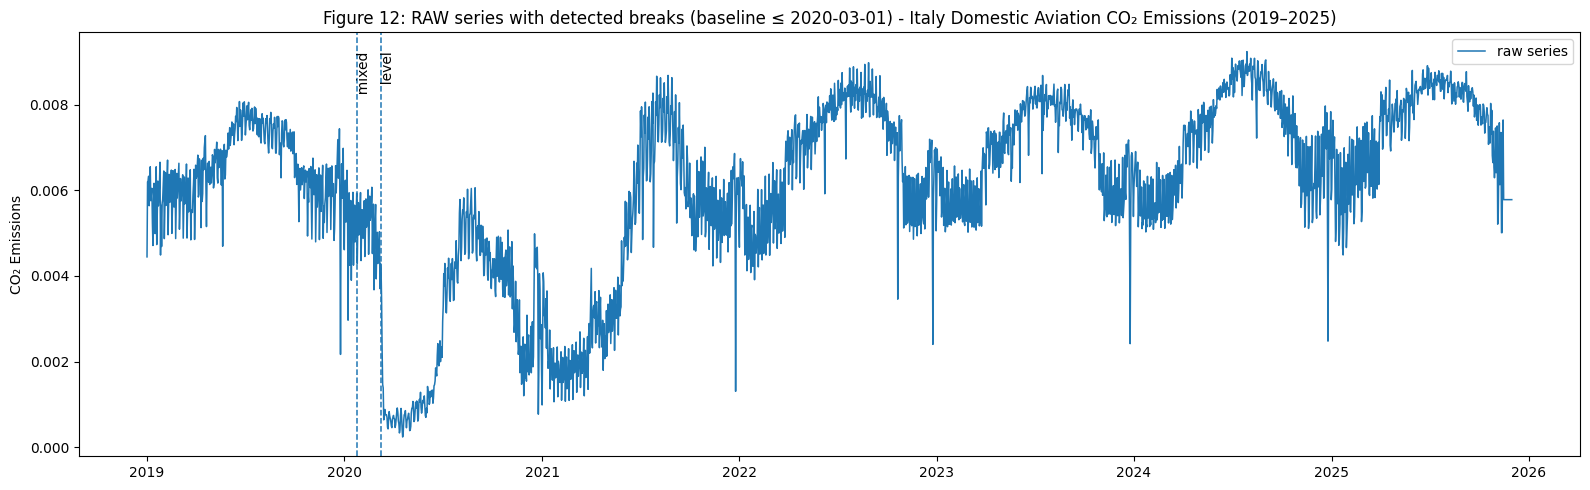

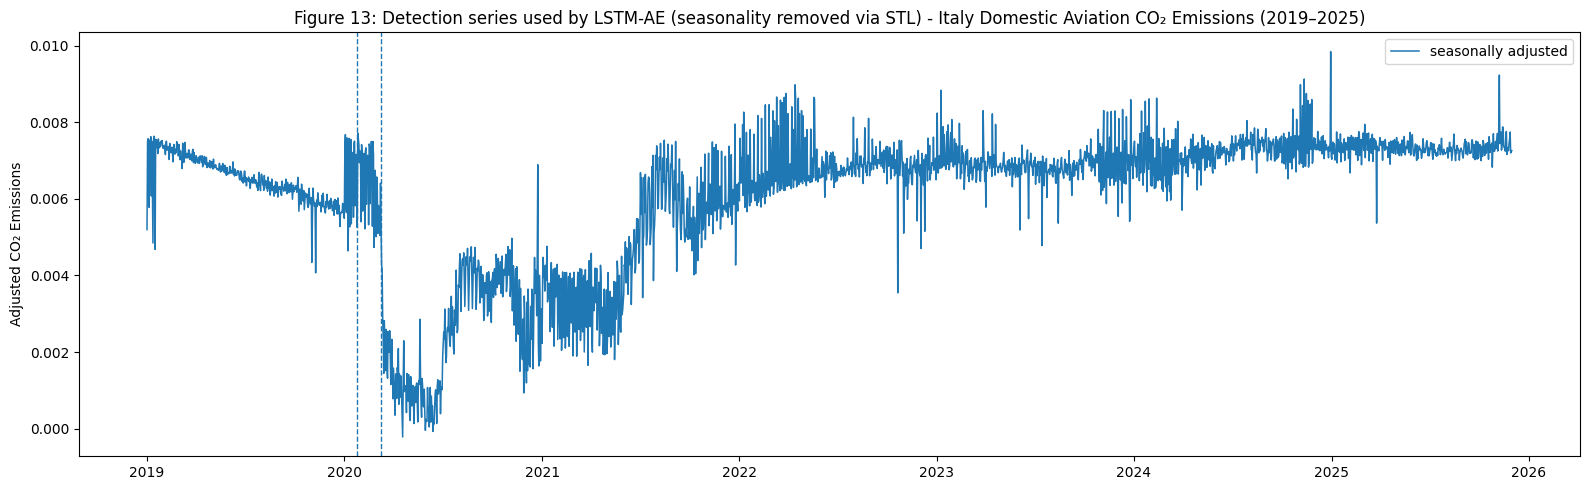

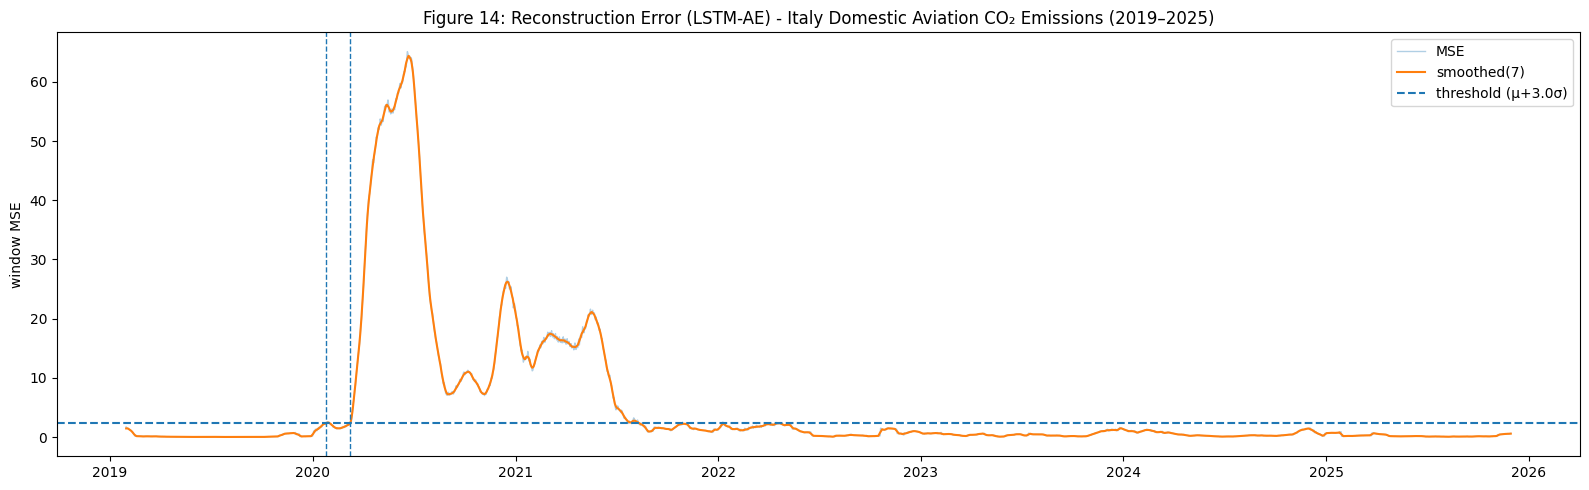

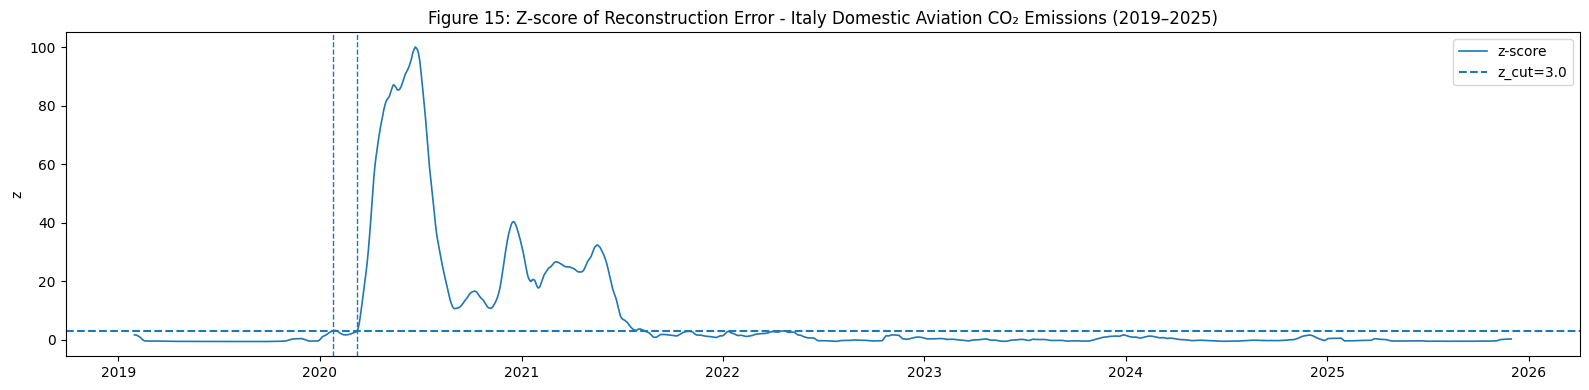

  break_date break_label  cohen_d_mean_shift  slope_pre  slope_post  \
0 2020-01-25       mixed           -1.119115  -0.000018   -0.000085   
1 2020-03-09       level           -6.840836  -0.000008   -0.000014   

   slope_rel_change       var_pre      var_post  var_ratio  pre_mean  \
0          3.736300  8.521840e-07  3.575519e-06   4.195713  0.005671   
1          0.637413  3.840217e-07  4.010936e-07   1.044455  0.005103   

   post_mean  
0   0.004002  
1   0.000817  


In [579]:
breaks_df, error_df, trained_model, detection_series, stl_components = detect_breaks_single_baseline_stl(
    df_in=italy_domestic_aviation_df,
    value_col="value",
    baseline_end="2020-03-01",

    seasonal_adjust=True,
    stl_period=365,
    stl_robust=True,

    seq_len=30,
    hidden_dim=64,
    n_epochs=10,
    batch_sz=128,
    learn_rate=0.001,

    smooth_win=7,
    z_cut=3.0,
    min_streak=7,

    pre_days=60,
    post_days=60,
    mean_d_thr=0.8,
    slope_rel_thr=1.0,
    var_ratio_thr=2.0,

    seed=42,
    make_plots=True
)

print(breaks_df)

Epoch 01/20 - train MSE: 0.881072
Epoch 02/20 - train MSE: 0.836056
Epoch 03/20 - train MSE: 0.817769
Epoch 04/20 - train MSE: 0.679897
Epoch 05/20 - train MSE: 0.502549
Epoch 06/20 - train MSE: 0.541919
Epoch 07/20 - train MSE: 0.423496
Epoch 08/20 - train MSE: 0.428802
Epoch 09/20 - train MSE: 0.433799
Epoch 10/20 - train MSE: 0.445290
Epoch 11/20 - train MSE: 0.402076
Epoch 12/20 - train MSE: 0.378276
Epoch 13/20 - train MSE: 0.371230
Epoch 14/20 - train MSE: 0.411367
Epoch 15/20 - train MSE: 0.377768
Epoch 16/20 - train MSE: 0.424265
Epoch 17/20 - train MSE: 0.385731
Epoch 18/20 - train MSE: 0.359708
Epoch 19/20 - train MSE: 0.388408
Epoch 20/20 - train MSE: 0.378110


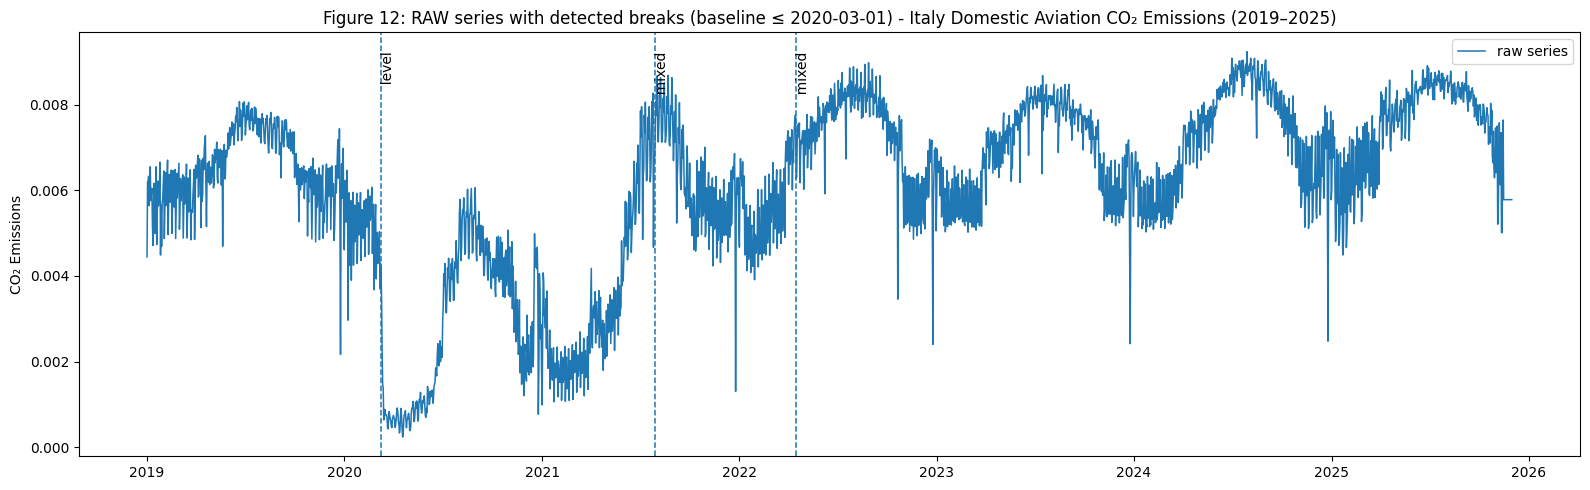

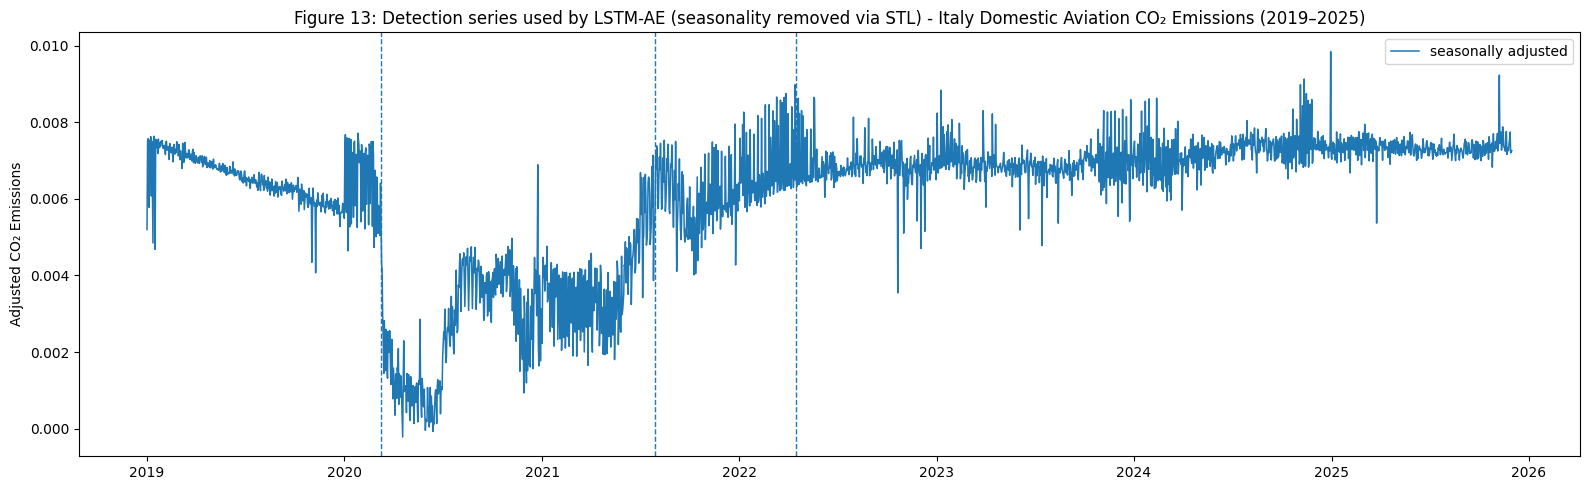

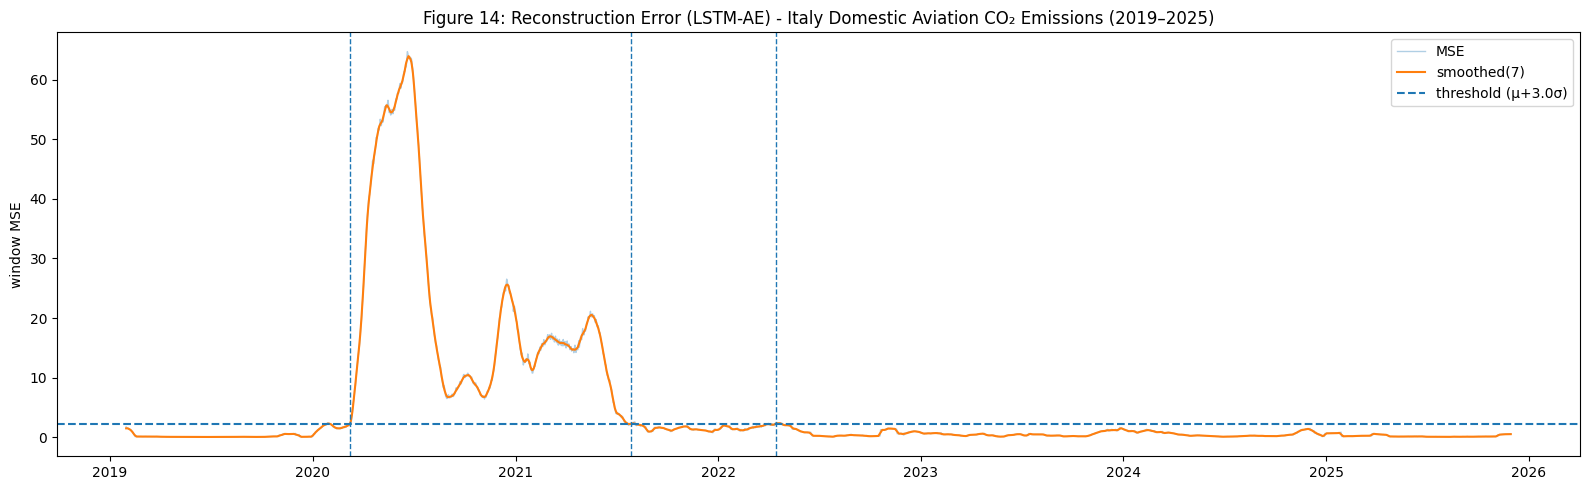

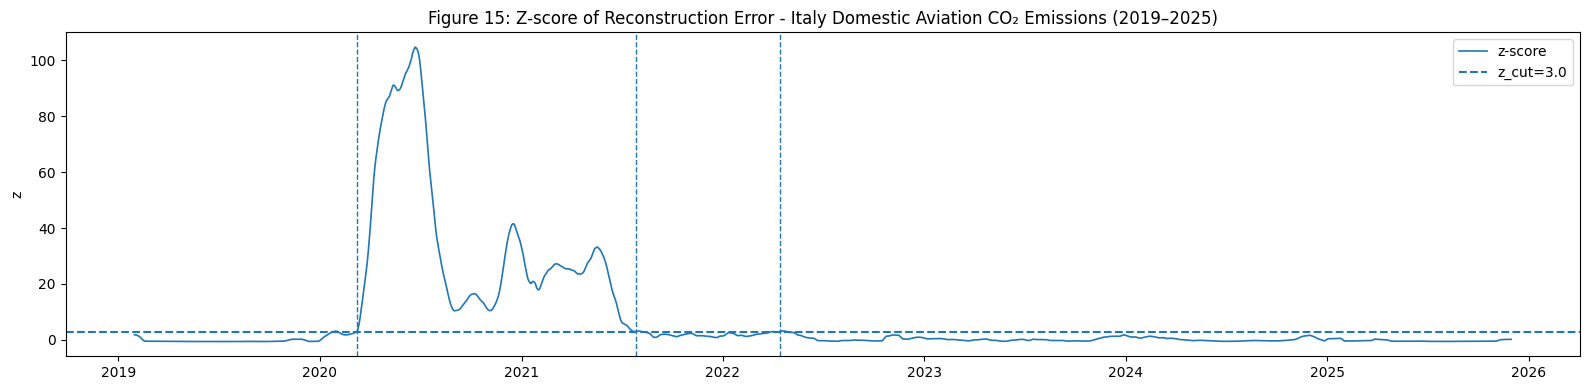

  break_date break_label  cohen_d_mean_shift  slope_pre  slope_post  \
0 2020-03-09       level           -6.840836  -0.000008   -0.000014   
1 2021-07-28       mixed            1.207025   0.000051   -0.000026   
2 2022-04-15       mixed            1.879287   0.000035    0.000014   

   slope_rel_change       var_pre      var_post  var_ratio  pre_mean  \
0          0.637413  3.840217e-07  4.010936e-07   1.044455  0.005103   
1          1.506242  1.433903e-06  6.498247e-07   2.206599  0.006094   
2          0.600219  7.665270e-07  2.656788e-07   2.885164  0.005976   

   post_mean  
0   0.000817  
1   0.007324  
2   0.007323  


In [580]:
breaks_df, error_df, trained_model, detection_series, stl_components = detect_breaks_single_baseline_stl(
    df_in=italy_domestic_aviation_df,
    value_col="value",
    baseline_end="2020-03-01",

    seasonal_adjust=True,
    stl_period=365,
    stl_robust=True,

    seq_len=30,
    hidden_dim=64,
    n_epochs=20,
    batch_sz=128,
    learn_rate=0.001,

    smooth_win=7,
    z_cut=3.0,
    min_streak=7,

    pre_days=60,
    post_days=60,
    mean_d_thr=0.8,
    slope_rel_thr=1.0,
    var_ratio_thr=2.0,

    seed=42,
    make_plots=True
)

print(breaks_df)

Epoch 01/30 - train MSE: 0.881072
Epoch 02/30 - train MSE: 0.836056
Epoch 03/30 - train MSE: 0.817769
Epoch 04/30 - train MSE: 0.679897
Epoch 05/30 - train MSE: 0.502549
Epoch 06/30 - train MSE: 0.541919
Epoch 07/30 - train MSE: 0.423496
Epoch 08/30 - train MSE: 0.428802
Epoch 09/30 - train MSE: 0.433799
Epoch 10/30 - train MSE: 0.445290
Epoch 11/30 - train MSE: 0.402076
Epoch 12/30 - train MSE: 0.378276
Epoch 13/30 - train MSE: 0.371230
Epoch 14/30 - train MSE: 0.411367
Epoch 15/30 - train MSE: 0.377768
Epoch 16/30 - train MSE: 0.424265
Epoch 17/30 - train MSE: 0.385731
Epoch 18/30 - train MSE: 0.359708
Epoch 19/30 - train MSE: 0.388408
Epoch 20/30 - train MSE: 0.378110
Epoch 21/30 - train MSE: 0.444297
Epoch 22/30 - train MSE: 0.391910
Epoch 23/30 - train MSE: 0.428594
Epoch 24/30 - train MSE: 0.383205
Epoch 25/30 - train MSE: 0.361793
Epoch 26/30 - train MSE: 0.334725
Epoch 27/30 - train MSE: 0.335793
Epoch 28/30 - train MSE: 0.337388
Epoch 29/30 - train MSE: 0.419463
Epoch 30/30 - 

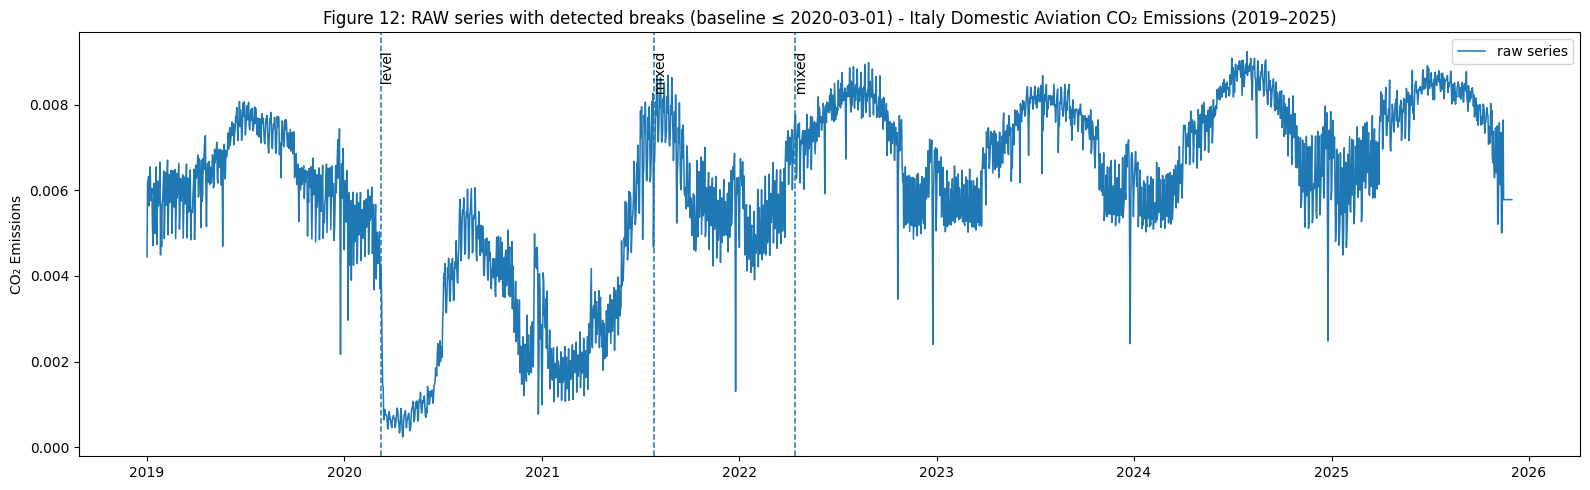

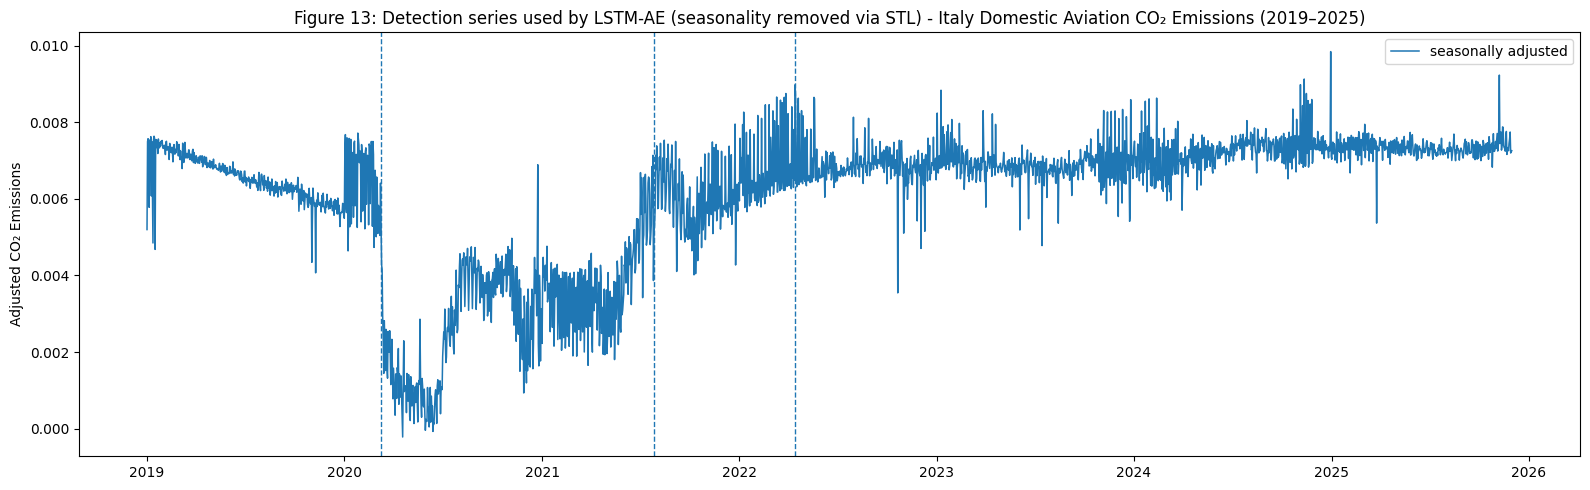

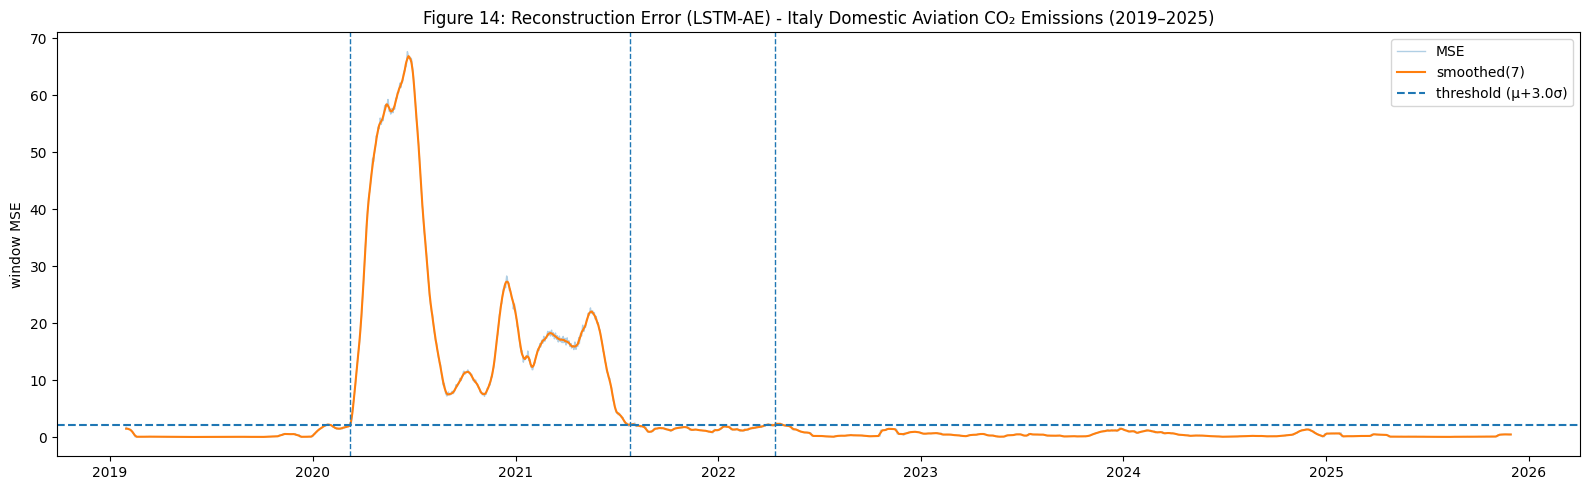

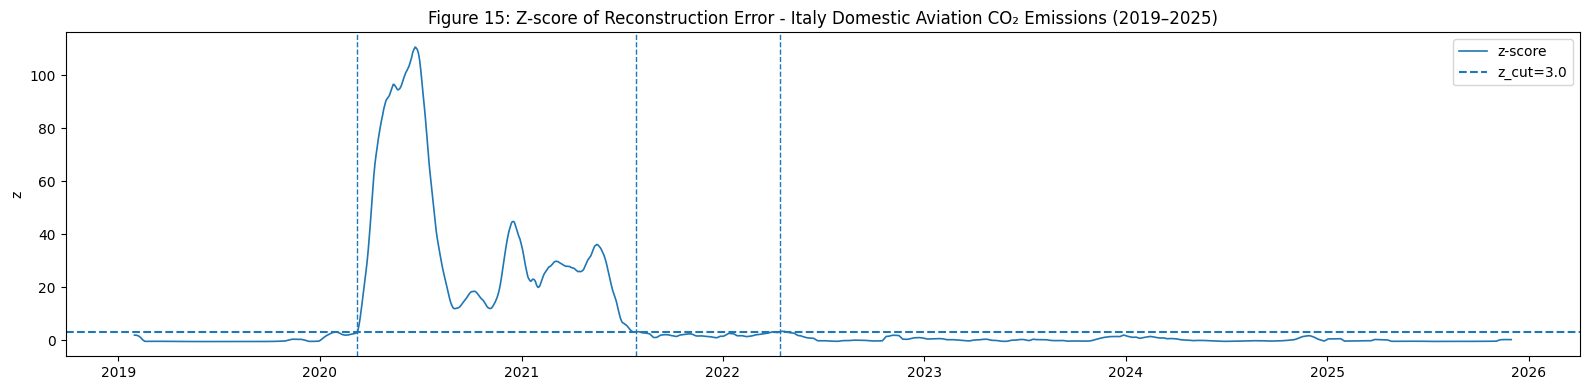

  break_date break_label  cohen_d_mean_shift  slope_pre  slope_post  \
0 2020-03-09       level           -6.840836  -0.000008   -0.000014   
1 2021-07-27       mixed            1.221172   0.000052   -0.000024   
2 2022-04-14       mixed            1.979967   0.000033    0.000013   

   slope_rel_change       var_pre      var_post  var_ratio  pre_mean  \
0          0.637413  3.840217e-07  4.010936e-07   1.044455  0.005103   
1          1.463740  1.455899e-06  6.567702e-07   2.216756  0.006064   
2          0.624262  7.212722e-07  2.638534e-07   2.733610  0.005934   

   post_mean  
0   0.000817  
1   0.007317  
2   0.007321  


In [581]:
breaks_df, error_df, trained_model, detection_series, stl_components = detect_breaks_single_baseline_stl(
    df_in=italy_domestic_aviation_df,
    value_col="value",
    baseline_end="2020-03-01",

    seasonal_adjust=True,
    stl_period=365,
    stl_robust=True,

    seq_len=30,
    hidden_dim=64,
    n_epochs=30,
    batch_sz=128,
    learn_rate=0.001,

    smooth_win=7,
    z_cut=3.0,
    min_streak=7,

    pre_days=60,
    post_days=60,
    mean_d_thr=0.8,
    slope_rel_thr=1.0,
    var_ratio_thr=2.0,

    seed=42,
    make_plots=True
)

print(breaks_df)

Epoch 01/40 - train MSE: 0.881072
Epoch 02/40 - train MSE: 0.836056
Epoch 03/40 - train MSE: 0.817769
Epoch 04/40 - train MSE: 0.679897
Epoch 05/40 - train MSE: 0.502549
Epoch 06/40 - train MSE: 0.541919
Epoch 07/40 - train MSE: 0.423496
Epoch 08/40 - train MSE: 0.428802
Epoch 09/40 - train MSE: 0.433799
Epoch 10/40 - train MSE: 0.445290
Epoch 11/40 - train MSE: 0.402076
Epoch 12/40 - train MSE: 0.378276
Epoch 13/40 - train MSE: 0.371230
Epoch 14/40 - train MSE: 0.411367
Epoch 15/40 - train MSE: 0.377768
Epoch 16/40 - train MSE: 0.424265
Epoch 17/40 - train MSE: 0.385731
Epoch 18/40 - train MSE: 0.359708
Epoch 19/40 - train MSE: 0.388408
Epoch 20/40 - train MSE: 0.378110
Epoch 21/40 - train MSE: 0.444297
Epoch 22/40 - train MSE: 0.391910
Epoch 23/40 - train MSE: 0.428594
Epoch 24/40 - train MSE: 0.383205
Epoch 25/40 - train MSE: 0.361793
Epoch 26/40 - train MSE: 0.334725
Epoch 27/40 - train MSE: 0.335793
Epoch 28/40 - train MSE: 0.337388
Epoch 29/40 - train MSE: 0.419463
Epoch 30/40 - 

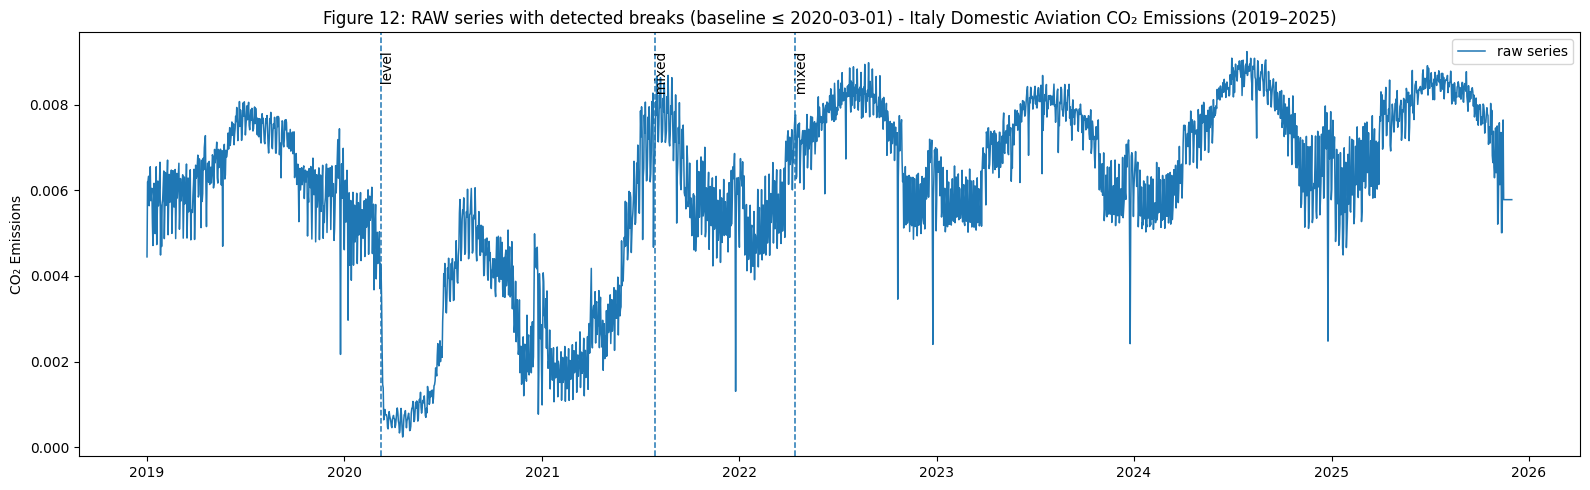

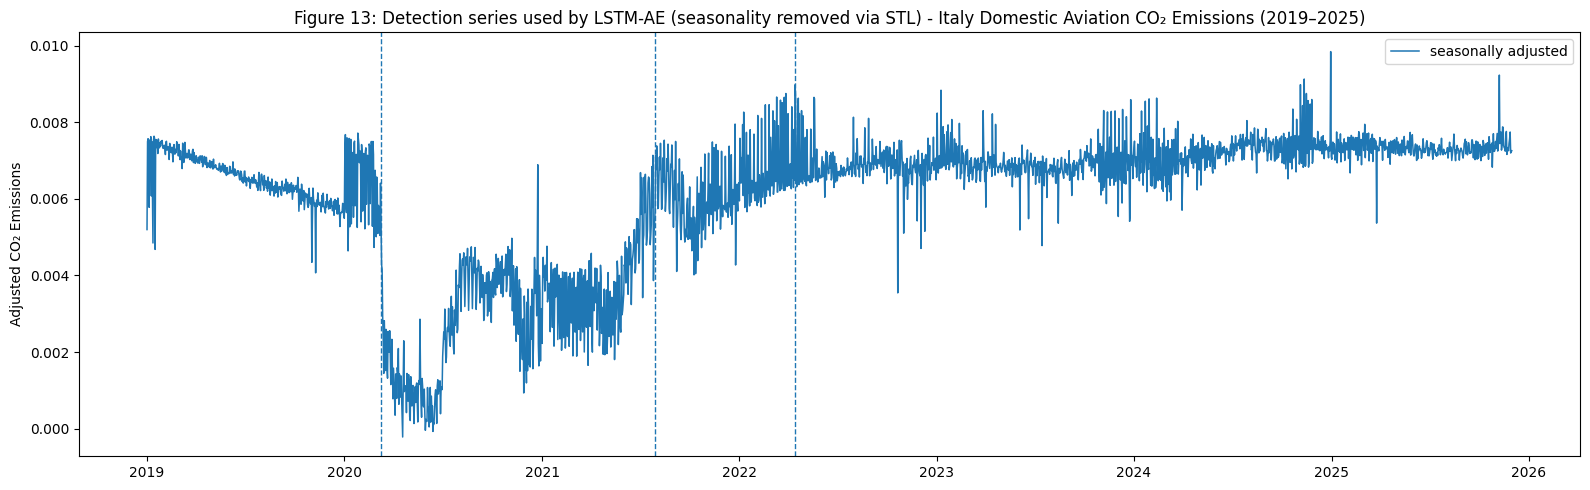

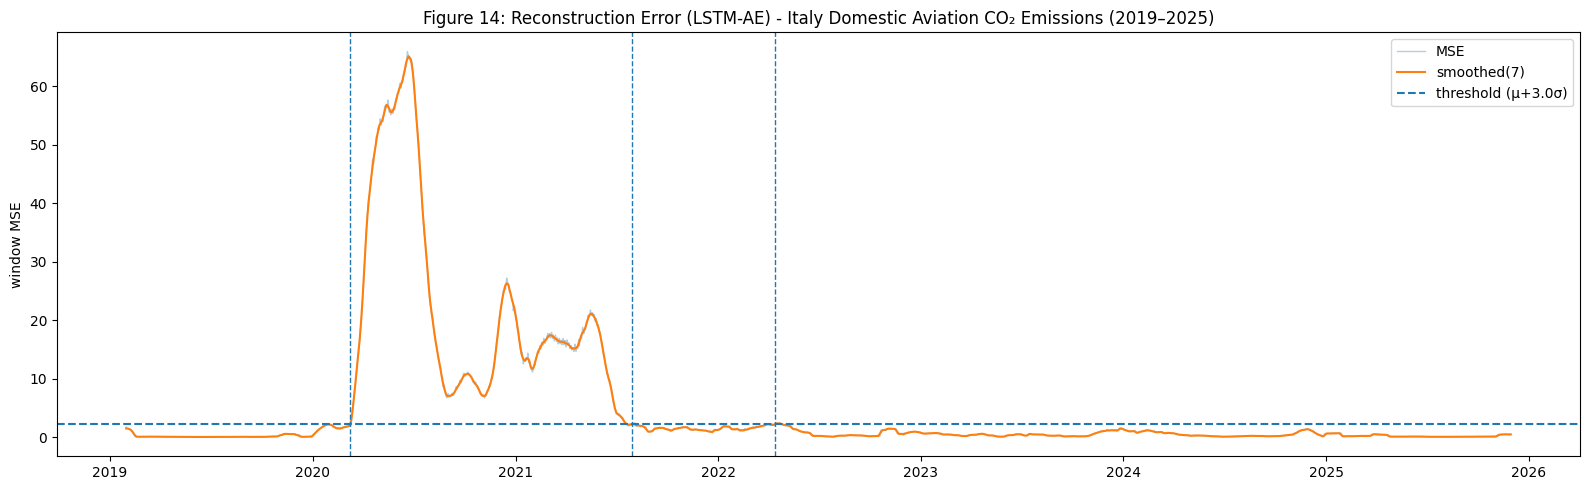

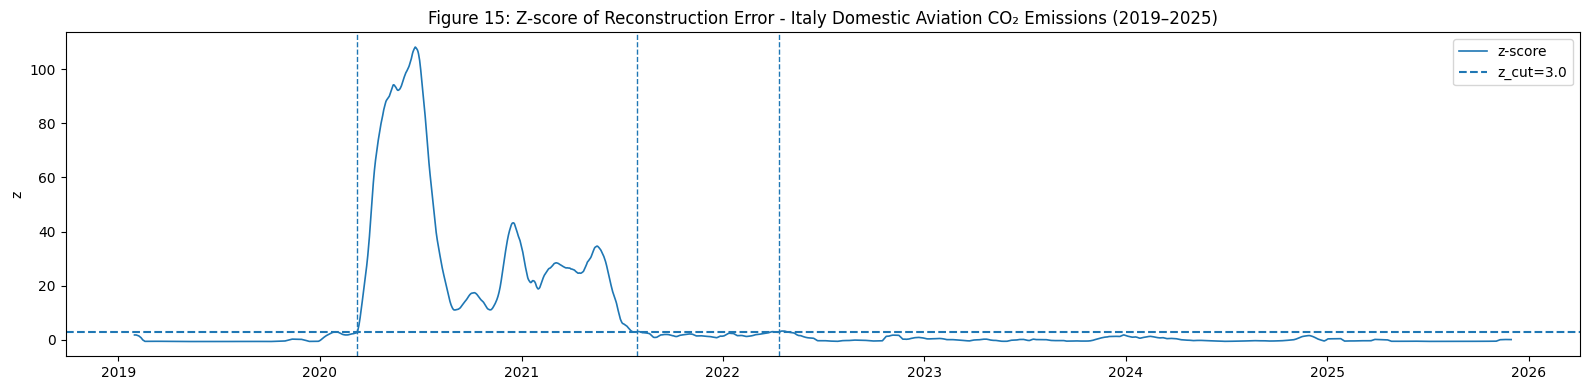

  break_date break_label  cohen_d_mean_shift  slope_pre  slope_post  \
0 2020-03-09       level           -6.840836  -0.000008   -0.000014   
1 2021-07-29       mixed            1.185475   0.000048   -0.000028   
2 2022-04-13       mixed            2.057230   0.000033    0.000011   

   slope_rel_change       var_pre      var_post  var_ratio  pre_mean  \
0          0.637413  3.840217e-07  4.010936e-07   1.044455  0.005103   
1          1.580022  1.346143e-06  6.490243e-07   2.074102  0.006142   
2          0.657986  7.162679e-07  2.601746e-07   2.753028  0.005882   

   post_mean  
0   0.000817  
1   0.007324  
2   0.007316  


In [582]:
breaks_df, error_df, trained_model, detection_series, stl_components = detect_breaks_single_baseline_stl(
    df_in=italy_domestic_aviation_df,
    value_col="value",
    baseline_end="2020-03-01",

    seasonal_adjust=True,
    stl_period=365,
    stl_robust=True,

    seq_len=30,
    hidden_dim=64,
    n_epochs=40,
    batch_sz=128,
    learn_rate=0.001,

    smooth_win=7,
    z_cut=3.0,
    min_streak=7,

    pre_days=60,
    post_days=60,
    mean_d_thr=0.8,
    slope_rel_thr=1.0,
    var_ratio_thr=2.0,

    seed=42,
    make_plots=True
)

print(breaks_df)

In [583]:
raise SystemExit("Execution stopped as requested.")

SystemExit: Execution stopped as requested.

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
country_df = df.copy()
country_domestic_aviation_df = country_df[country_df['sector'] == 'Domestic Aviation']
country_domestic_aviation_df = country_domestic_aviation_df.drop(columns=['sector'], errors='ignore')
country_domestic_aviation_df.head()

In [ ]:
country_emissions = country_domestic_aviation_df.groupby('country')['value'].sum().reset_index()
country_emissions = country_emissions.rename(columns={'value': 'total_domestic_aviation_emissions'})

top_10_countries = country_emissions.sort_values(by='total_domestic_aviation_emissions', ascending=False).head(10)

plt.figure(figsize=(14, 7))
sns.barplot(x='country', y='total_domestic_aviation_emissions', data=top_10_countries, palette='viridis', legend=False)
plt.title('Top 10 Countries by Total Domestic Aviation Emissions')
plt.xlabel('Country')
plt.ylabel('Total Domestic Aviation Emissions')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
top_10_country_names = top_10_countries['country'].tolist()

country_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'].isin(top_10_country_names)]

print("DataFrame updated to include only top 10 countries by domestic aviation emissions.")

unique_countries_top_10 = country_domestic_aviation_df['country'].unique()
print("Unique Countries:")
for country in unique_countries_top_10:
    print(f"- {country}")



In [ ]:
country_record_counts = country_domestic_aviation_df.groupby('country').size().reset_index(name='record_count')

plt.figure(figsize=(14, 7))
ax = sns.barplot(x='country', y='record_count', data=country_record_counts, palette='viridis', legend=False)
plt.title('Number of Records per Country in Domestic Aviation Data')
plt.xlabel('Country')
plt.ylabel('Number of Records')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
united_states_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'United States'].copy()
china_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'China'].copy()
india_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'India'].copy()
russian_federation_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Russian Federation'].copy()
japan_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Japan'].copy()
brazil_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Brazil'].copy()
france_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'France'].copy()
spain_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Spain'].copy()
italy_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Italy'].copy()
united_kingdom_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'United Kingdom'].copy()

In [ ]:
dfs = [
    united_states_domestic_aviation_df.assign(country='United States'),
    china_domestic_aviation_df.assign(country='China'),
    india_domestic_aviation_df.assign(country='India'),
    russian_federation_domestic_aviation_df.assign(country='Russian Federation'),
    japan_domestic_aviation_df.assign(country='Japan'),
    brazil_domestic_aviation_df.assign(country='Brazil'),
    france_domestic_aviation_df.assign(country='France'),
    spain_domestic_aviation_df.assign(country='Spain'),
    italy_domestic_aviation_df.assign(country='Italy'),
    united_kingdom_domestic_aviation_df.assign(country='United Kingdom')
]


In [ ]:
monthly = (
    country_domestic_aviation_df
    .set_index("date")
    .groupby("country")["value"]
    .resample("ME")
    .mean()
    .reset_index()
)
display(monthly.head())
display("Shape",monthly.shape)


In [ ]:
plt.figure(figsize=(18, 9))
sns.lineplot(data=monthly, x='date', y='value', hue='country', palette='tab10', linewidth=1.5)
plt.title('Domestic Aviation Emissions Over Time for Top 10 Countries', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Emissions Value', fontsize=12)
plt.legend(title='Country', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
pivot = monthly.pivot_table(index="country", columns="date", values="value", aggfunc="mean")

print("Pivot shape (countries x time):", pivot.shape)
display(pivot.head(10))

In [ ]:
X = pivot.values.astype(float)
X_ts = X[:, :, None]
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
X_scaled = scaler.fit_transform(X_ts)

In [ ]:
pd.DataFrame(X_scaled[:, :, 0]).head(10)

In [ ]:
df_plot = pd.DataFrame(
    X_scaled[:, :, 0],
    index=pivot.index,
    columns=pivot.columns
)

plt.figure(figsize=(12,6))

for country in df_plot.index:
    plt.plot(df_plot.columns, df_plot.loc[country], label=country)

plt.title("Standardized CO2 Emissions Time Series")
plt.xlabel("Date")
plt.ylabel("Scaled Emissions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
k_values = range(2, 11)
inertias = []

for k in k_values:
    km = TimeSeriesKMeans(
        n_clusters=k,
        metric="dtw",
        metric_params={"global_constraint": "itakura", "itakura_max_slope": 2.0},
        max_iter=50,
        n_init=3,
        random_state=42,
        verbose=False
    )
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_values), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster DTW sum)")
plt.title("Elbow Plot (DTW TimeSeriesKMeans)")
plt.xticks(list(k_values))
plt.grid(True)
plt.show()


In [ ]:
k = 3

dtw_km = TimeSeriesKMeans(
    n_clusters=k,
    metric="dtw",
    metric_params={"global_constraint": "itakura", "itakura_max_slope": 2.0},
    random_state=42,
    n_init=5,
    max_iter=50,
    verbose=False
)

dtw_labels = dtw_km.fit_predict(X_scaled)

cluster_df = pd.DataFrame({"country": pivot.index, "dtw_cluster": dtw_labels})
cluster_df = cluster_df.sort_values("dtw_cluster")

print("DTW clusters:")
display(cluster_df)


In [ ]:
for c in range(k):
    members = cluster_df[cluster_df["dtw_cluster"] == c]["country"].tolist()
    print(f"Cluster {c}: {members}")

In [ ]:
dates = pivot.columns

for c in range(k):
    members = np.where(dtw_labels == c)[0]
    plt.figure(figsize=(14, 5))
    for idx in members:
        plt.plot(dates, X_scaled[idx, :, 0], alpha=0.6, linewidth=1)

    center = dtw_km.cluster_centers_[c, :, 0]
    plt.plot(dates, center, linewidth=3, label="Cluster center")

    plt.title(f"DTW Cluster {c} (standardized emission trends)")
    plt.xlabel("Date (monthly)")
    plt.ylabel("Standardized emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
centers = dtw_km.cluster_centers_[:, :, 0].astype(np.float64)

center_dist = np.zeros((k, k), dtype=np.float64)

for i in range(k):
    for j in range(k):
        center_dist[i, j] = dtw(
            centers[i],
            centers[j],
            global_constraint="itakura",
            itakura_max_slope=2.0
        )

plt.figure(figsize=(6, 5))
plt.imshow(center_dist)
plt.colorbar(label="DTW distance")
plt.xticks(range(k), [f"C{i}" for i in range(k)])
plt.yticks(range(k), [f"C{i}" for i in range(k)])
plt.title("DTW distances between cluster centers")
plt.tight_layout()
plt.show()

In [ ]:
k = 4

dtw_km = TimeSeriesKMeans(
    n_clusters=k,
    metric="dtw",
    metric_params={"global_constraint": "itakura", "itakura_max_slope": 2.0},
    random_state=42,
    n_init=5,
    max_iter=50,
    verbose=False
)

dtw_labels = dtw_km.fit_predict(X_scaled)

cluster_df = pd.DataFrame({"country": pivot.index, "dtw_cluster": dtw_labels})
cluster_df = cluster_df.sort_values("dtw_cluster")

print("DTW clusters:")
display(cluster_df)

In [ ]:
for c in range(k):
    members = cluster_df[cluster_df["dtw_cluster"] == c]["country"].tolist()
    print(f"Cluster {c}: {members}")

In [ ]:
dates = pivot.columns

for c in range(k):
    members = np.where(dtw_labels == c)[0]
    plt.figure(figsize=(14, 5))
    for idx in members:
        plt.plot(dates, X_scaled[idx, :, 0], alpha=0.6, linewidth=1)

    center = dtw_km.cluster_centers_[c, :, 0]
    plt.plot(dates, center, linewidth=3, label="Cluster center")

    plt.title(f"DTW Cluster {c} (standardized emission trends)")
    plt.xlabel("Date (monthly)")
    plt.ylabel("Standardized emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
centers = dtw_km.cluster_centers_[:, :, 0].astype(np.float64)

center_dist = np.zeros((k, k), dtype=np.float64)

for i in range(k):
    for j in range(k):
        center_dist[i, j] = dtw(
            centers[i],
            centers[j],
            global_constraint="itakura",
            itakura_max_slope=2.0
        )

plt.figure(figsize=(6, 5))
plt.imshow(center_dist)
plt.colorbar(label="DTW distance")
plt.xticks(range(k), [f"C{i}" for i in range(k)])
plt.yticks(range(k), [f"C{i}" for i in range(k)])
plt.title("DTW distances between cluster centers")
plt.tight_layout()
plt.show()